## This script should perform the FBA simulations for growth on glucose and generate a plot
The Plot is inspired by Guo et al. 2022
# Plot for Ppa required before removing this file is possible

In [249]:
# imports
import cobra
import yaml
import pandas
from cobra.flux_analysis import pfba
from cobra.medium import minimal_medium


import sys # append path

sys.path.append('../scripts/')
import helperFunction as hf

### If you want to reload the hf without closing the file or vs code: 
# from importlib import reload
# reload(hf)

# config
config_name = 'model_config'
config_path = f'../config/{config_name}.yaml'

# load config
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)


In [2]:
# # load all models at once
# model_names = list(config['models'].keys())
# _sep = config['seperator']
# yeast_models = ['ppa1026v3', 'yli21', 'yli4']
# models = {}
# for model, path in config['models'].items():
#     models[model] = cobra.io.read_sbml_model(path)

# ## Check names of the yeast models:
# for model in yeast_models:
#     print(models[model].name)


In [2]:
# experimental data:
## ppa: https://www.notion.so/Growth-rates-of-engineered-strains-fd69830a7b13471da65404a24c4a7abe?pvs=4#808d8f5f4f894c8e99baa3205455c664
ppa_oxygen_concentration = ['normoxic', 'hypoxic']
ppa_o2_uptake = [0.0, 0.0]
ppa_carbon_source = ['glucose', 'glucose']
ppa_glucose_consumption = [1.0, 1.72]
ppa_experimental_growth = [0.1, 0.1]
ppa_carbon_source = ['glycerol', 'glycerol', 'glycerol']
ppa_glycerol_uptake = [0.58, 0.85, 1.07, 1.52, 1.92, 2.41]
# ppa_glycerol_uptake = [0.035, 0.05, 0.065, 0.1, 0.13, 0.16] #dilution rate?
ppa_metanol_uptake = [1.22, 1.73, 2.33, 2.96, 3.47]
ppa_glycerol_o2_uptake = [-0.82, -1.26, -1.52, -2.04, -2.36, -2.92] # O2 consumption
ppa_glycerol_co2_production = [0.53, 0.84, 1.00, 1.28, 1.41, 1.74] # CO2 production
ppa_metanol_o2_uptake = [-2.98, -4.07, -4.97, -6.36, -8.22]
ppa_experimental_glycerol = [0.035, 0.050, 0.065, 0.100, 0.130, 0.160]


# everthing is normoxic for yli (27.03.2023)
# # experimental data from Chen et al. 2020 Comparison: https://link.springer.com/article/10.1007/s12257-019-0208-1#Sec1 supplementary table 1
# ref; Uptake Glucose; Growth rate
# [1]     0.95             0.08
# [2]     0.33             0.03
# [2]     0.72             0.07
# [2]     0.98             0.1
# [2]     2.09             0.2
# [4]     2.46             0.24 (suspicious because no information about oxygen concentration provided)
## yli: https://www.sciencedirect.com/science/article/pii/S200103702200174X?via%3Dihub
yli_glucose_uptake = [2.43, 0.61, 0.64, 0.95, 0.33, 0.72, 0.98, 2.09]
yli_experimental_growth = [0.26, 0.047, 0.048, 0.08, 0.03, 0.07, 0.1, 0.2]
yli_xu_glucose_uptake = [0.95, 0.33, 0.72, 0.98, 2.09, 0.61, 0.64, 2.46]


## Compute growth rates based on model
- find glucose and fructose exchange reactions
- set medium accodringly
- table of growth rate

In [ ]:
# #### functions 
# def restore_bounds(model, model_bounds):
#     for r in model.reactions:
#         r.lower_bound, r.upper_bound = model_bounds[r.id]

### iYli21

In [254]:
# iYli21:
iYli21_model_path = config['models']['yli21']
iYli21_model = cobra.io.read_sbml_model(iYli21_model_path)

# storing default bounds
# iYli21_model_bounds = {r.id:(r.lower_bound, r.upper_bound) for r in iYli21_model.reactions}

# growth on glucose
iYli21_model.summary() # 0.283

In [261]:
# investigate Uptake of the model
summary = iYli21_model.summary()
uptake_tbl = summary.uptake_flux
uptake_rxns = [iYli21_model.reactions.get_by_id(r_id) for r_id in list(uptake_tbl.reaction)]
hf.reactionInformationPrint(uptake_rxns)

AttributeError: 'str' object has no attribute 'name'

In [4]:
# check model numbers
with iYli21_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges))
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()]) # default: biomass_C

Reactions:  2285
Metabolites:  1868
Genes:  1058
Exchange:  182
glucose exchange:  ['R1070']
biomass reaction:  [('R1372', 'yeast 5 biomass pseudoreaction'), ('R1373', 'growth'), ('R1387', 'yeast 6 biomass pseudoreaction'), ('R1710', 'yeast 8 biomass pseudoreaction'), ('xBIOMASS', 'xBIOMASS'), ('xMAINTENANCE', 'Non-growth associated maintenance (NGAM)'), ('biomass_C', 'biomass_C')]


In [99]:
## bounds of biomass reaction
for r in iYli21_model.reactions:
    if 'biomass' in r.name.lower():
        print(r.id, r.name, r.lower_bound, r.upper_bound)

R1372 yeast 5 biomass pseudoreaction 0.0 0.0
R1387 yeast 6 biomass pseudoreaction 0.0 0.0
R1710 yeast 8 biomass pseudoreaction 0.0 0.0
xBIOMASS xBIOMASS 0.0 1000.0
biomass_C biomass_C 0.0 1000.0


In [13]:
# generate data for plot
print(iYli21_model.id)
iYli21_glucose_exchange_reaction = 'R1070'
iYli21_biomass = 'biomass_C'
# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
iYli21_simulation_growth = []
for condition in yli_glucose_uptake:
    with iYli21_model as model:
        dGlu = model.reactions.get_by_id(iYli21_glucose_exchange_reaction)
        dGlu.bounds = (-condition, 1000)
        sol = model.optimize()
        growthRate = sol.objective_value
        # iYli21_pfba_solution = pfba(iYli21_model)
        # growthRate = iYli21_pfba_solution.fluxes[iYli21_biomass]
        iYli21_simulation_growth.append(growthRate)
        print(f'Growth rate on {condition} mmol/h glucose: {growthRate}')

M_iYli21
Growth rate on 2.43 mmol/h glucose: 0.282703723990443
Growth rate on 0.61 mmol/h glucose: 0.03133039072588781
Growth rate on 0.64 mmol/h glucose: 0.035480781742888


### iYali4

In [210]:
# iYali4:
iYali4_model_path = config['models']['yli4']
iYali4_model = cobra.io.read_sbml_model(iYali4_model_path)

iYali4_dl = cobra.io.read_sbml_model(config['models']['yli4_dl'])


Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_1 "(R)-lactate:ferricytochrome-c 2-oxidoreductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_1 "(R)-lactate:ferricytochrome-c 2-oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_2 "(R)-lactate:ferricytochrome-c 2-oxidoreductase">
Use of GENE ASSOCIATION or GENE_ASSOCIATION in the notes element is discouraged, use fbc:gpr instead: <Reaction R_2 "(R)-lactate:ferricytochrome-c 2-oxidoreductase">
Encoding LOWER_BOUND and UPPER_BOUND in KineticLaw is discouraged, use fbc:fluxBounds instead: <Reaction R_4 "(S)-lactate:ferricytochrome-c 2-oxidore

In [212]:
 # default: 2111: growth# check model numbers
with iYali4_dl as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    # print('Exchange: ', len(model.exchanges))
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Reactions:  1985
Metabolites:  1683
Genes:  901
glucose exchange:  ['1714']
biomass reaction:  [('2110', 'yeast 5 biomass pseudoreaction'), ('2111', 'growth'), ('2133', 'yeast 6 biomass pseudoreaction'), ('4041', 'yeast 8 biomass pseudoreaction'), ('xBIOMASS', 'Biomass production'), ('xMAINTENANCE', 'Non-growth associated maintenance (NGAM)')]


In [216]:
# sol = iYali4_model.summary()
# uptake_rxns = sol.uptake_flux['reaction'].tolist()
# for rxn_id in uptake_rxns:
#     rxn = iYali4_model.reactions.get_by_id(rxn_id)
#     print(rxn_id, rxn.name, rxn.reaction, rxn.bounds)
# iYali4_model.summary() #0.0566

# check for dl model
sol = iYali4_dl.summary()
uptake_rxns = sol.uptake_flux['reaction'].tolist()
for rxn_id in uptake_rxns:
    rxn = iYali4_dl.reactions.get_by_id(rxn_id)
    print(rxn_id, rxn.name, rxn.reaction, rxn.bounds)
iYali4_dl.summary() #0.0566

1654 ammonium exchange m1031 <=>  (-1000.0, 1000.0)
1714 D-glucose exchange m511 <=>  (-0.649, 1000.0)
1832 H+ exchange m342 <=>  (-1000.0, 1000.0)
1992 oxygen exchange m1339 <=>  (-1000.0, 1000.0)
2005 phosphate exchange m215 <=>  (-1000.0, 1000.0)
2060 sulphate exchange m1113 <=>  (-1000.0, 1000.0)


In [218]:
# generate data for plot
print(iYali4_model.id)
iYali4_glucose_exchange_reaction = '1714'
iYali4_biomass = '2111'
# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
iYali4_simulation_growth = []
for condition in yli_glucose_uptake:
    with iYali4_model as model:
        dGlu = model.reactions.get_by_id(iYali4_glucose_exchange_reaction)
        dGlu.bounds = (-condition, 1000)
        sol = model.optimize()
        growthRate = sol.objective_value
        # iYali4_pfba_solution = pfba(iYali4_model)
        # growthRate = iYali4_pfba_solution.fluxes[iYali4_biomass]
        iYali4_simulation_growth.append(growthRate)
        print(f'Growth rate on {condition} mmol/h glucose: {growthRate}')


### Summary: Exact same results for iYali4 and iYali4_dl -> not the same results as in the iYli21 paper
# normal iYali4 model
# Growth rate on 2.43 mmol/h glucose: 0.21206481122503662
# Growth rate on 0.61 mmol/h glucose: 0.05323437648035952
# Growth rate on 0.64 mmol/h glucose: 0.05585246056955728
# Growth rate on 0.95 mmol/h glucose: 0.08290599615793628
# Growth rate on 0.33 mmol/h glucose: 0.028798924981177962
# Growth rate on 0.72 mmol/h glucose: 0.06283401814075165
# Growth rate on 0.98 mmol/h glucose: 0.08552408024713447
# Growth rate on 2.09 mmol/h glucose: 0.18239319154746075

# dl iYali4 model
# Growth rate on 2.43 mmol/h glucose: 0.21206481122503662
# Growth rate on 0.61 mmol/h glucose: 0.05323437648035952
# Growth rate on 0.64 mmol/h glucose: 0.05585246056955728
# Growth rate on 0.95 mmol/h glucose: 0.08290599615793628
# Growth rate on 0.33 mmol/h glucose: 0.028798924981177962
# Growth rate on 0.72 mmol/h glucose: 0.06283401814075165
# Growth rate on 0.98 mmol/h glucose: 0.08552408024713447
# Growth rate on 2.09 mmol/h glucose: 0.18239319154746075

MODEL1508190002
Growth rate on 2.43 mmol/h glucose: 0.21206481122503662
Growth rate on 0.61 mmol/h glucose: 0.05323437648035952
Growth rate on 0.64 mmol/h glucose: 0.05585246056955728
Growth rate on 0.95 mmol/h glucose: 0.08290599615793628
Growth rate on 0.33 mmol/h glucose: 0.028798924981177962
Growth rate on 0.72 mmol/h glucose: 0.06283401814075165
Growth rate on 0.98 mmol/h glucose: 0.08552408024713447
Growth rate on 2.09 mmol/h glucose: 0.18239319154746075


In [7]:
hf.mediumAnalysis(iYali4_model)


----- media analysis -----
ammonium exchange, (id: 1654) is active. (Bounds: (-1000.0, 1000.0))
D-glucose exchange, (id: 1714) is active. (Bounds: (-0.649, 1000.0))
H+ exchange, (id: 1832) is active. (Bounds: (-1000.0, 1000.0))
oxygen exchange, (id: 1992) is active. (Bounds: (-1000.0, 1000.0))
phosphate exchange, (id: 2005) is active. (Bounds: (-1000.0, 1000.0))
sulphate exchange, (id: 2060) is active. (Bounds: (-1000.0, 1000.0))
water exchange, (id: 2100) is active. (Bounds: (-1000.0, 1000.0))
--------------------------


### iMK735 (failed twice but worked in the end)

In [90]:
# load model
iMK735_model_path = config['models']['yliMK735']
iMK735_model = cobra.io.read_sbml_model(iMK735_model_path)

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


In [92]:
# check model numbers
with iMK735_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges))
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()]) # default: biomass_C


Reactions:  1342
Metabolites:  1115
Genes:  735
Exchange:  123
glucose exchange:  ['EX_glc(e)']
biomass reaction:  [('biomass_004', 'biomass yarrowia 0.4% bal YL'), ('biomass_013', 'biomass yarrowia 1.3% bal YL'), ('biomass_051', 'biomass yarrowia 5.1% bal YL'), ('biomass_20', 'biomass yarrowia 20% bal YL'), ('biomass_40', 'biomass yarrowia 40% bal YL'), ('biomass_60', 'biomass yarrowia 60% bal YL'), ('biomass_80', 'biomass yarrowia 80% bal YL'), ('biomass_WOtag', 'biomass WOtag YL'), ('biomass_WOtG', 'biomass WOtag and glycogen YL'), ('biomass_C', 'biomass_C')]


In [95]:
# set objective
iMK735_model.objective = 'biomass_C'

# # default growth
iMK735_model.summary() # infeasible

# # check medium
# hf.mediumAnalysis(iMK735_model)
# # everything is active by default

# # find biomass reaction
# for r in iMK735_model.reactions:
#     if 'biomass' in r.name.lower():
#         print(r.id, r.name, r.lower_bound, r.upper_bound)

# # investigate and set biomass: (biomass bounds should be from 0 to 1000)
# biomass = iMK735_model.reactions.get_by_id('biomass_013')


# # # In silico minimal medium (iMM) was used for the calculations, allowing for free uptake of CO2, H2O, H+, inositol, K+, NH4+, Na+, O2, HPO42− and SO42−.
# imm = ['EX_co2_b', 'EX_h2o_b', 'EX_h_b', 'EX_inost_b', 'EX_k_b', 'EX_nh4_b', 'EX_na1_b', 'EX_o2_b', 'EX_pi_b', 'EX_so4_b']

# # check if EX_pi_b is reaction of h2po4 
# phosphate_reac = iMK735_model.reactions.EX_pi_b
# phosphate_formula = list(phosphate_reac.metabolites)[0]
# phosphate_formula #name: HO4P

# # set every exchage reaction to 0
# for r in iMK735_model.exchange:
#     r.bounds = (-1000, 0)

# # e.g. EX_co2_b: co2_b <--
# for r_id in imm:
#     r = iMK735_model.reactions.get_by_id(r_id)
#     r.bounds = (-1000, 1000)

# # glucose: EX_glc_D_b
# iMK735_model.reactions.get_by_id('EX_glc(e)') # glc_D[e] <=>

# # # check objective function
# iMK735_model.summary()

# # check if exchange reactions equal to boundary reactions
# exchange_rxn = [rxn.id for rxn in iMK735_model.exchanges]
# exchange_rxn.sort()


# # check boundary reactions
# boundary_rxn = [rxn.id for rxn in iMK735_model.boundary]
# boundary_rxn.sort()
# print(boundary_rxn == exchange_rxn) # exchange_rxn == boundary_rxn

# # check exchange reactions and their bounds 
# for r in iMK735_model.exchanges:
#     print(r.id, r.name, r.bounds)
# # => All exchange reactions are set to (-1000, 1000) but FBA is infeasible

In [96]:
# generate data for plot
print(iMK735_model.id)
iMK735_glucose_exchange_reaction = 'EX_glc(e)'
iMK735_biomass = 'biomass_C'
# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
iMK735_simulation_growth = []
for condition in yli_glucose_uptake:
    with iMK735_model as model:
        dGlu = model.reactions.get_by_id(iMK735_glucose_exchange_reaction)
        dGlu.bounds = (-condition, 1000)
        sol = model.optimize()
        growthRate = sol.objective_value
        # iMK735_pfba_solution = pfba(iMK735_model)
        # growthRate = iMK735_pfba_solution.fluxes[iMK735_biomass]
        iMK735_simulation_growth.append(growthRate)
        print(f'Growth rate on {condition} mmol/h glucose: {growthRate}')

M_model
Growth rate on 2.43 mmol/h glucose: 0.2514247086681079
Growth rate on 0.61 mmol/h glucose: 0.05847129503238381
Growth rate on 0.64 mmol/h glucose: 0.06165184580659825


In [18]:
compartments = iMK735_model.compartments
compartments['Extra_organism'] = 'extraellular'
iMK735_model.compartments

{'Cytosol': '',
 'Mitochondria': '',
 'Extra_organism': '',
 'Nucleus': '',
 'Peroxisome': '',
 'Endoplasmic_Reticulum': '',
 'Golgi_Apparatus': '',
 'Vacuole': ''}

In [34]:
## apply minimal media 
from cobra.medium import minimal_medium
iMK735_minimal_media = minimal_medium(iMK735_model)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Minimization of medium was infeasible.


In [29]:
## find glucose exchange
iMK735_model.medium # everything is 1000 in the beginning
iMK735_glucose_exchange_reaction = 'EX_glc_D_b'
mK_glucose = iMK735_model.reactions.get_by_id(iMK735_glucose_exchange_reaction)
mK_glucose.bounds = (-2.43, 1000)
iMK735_model.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
/Users/ampholyt/Coding/BSEP22/Code/With_Bockmayr/EFM_calculation_cobamp/venv/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


<Solution infeasible at 0x15efacb50>

In [48]:
# ammonium (nh4_e, EX_nh4_b), carbon dioxide (EX_co2_b), h+ (EX_h_b), iron, oxygen (EX_o2_b), phosphate (pi_e, EX_pi_b), potassium (k_e, EX_k_b), sodium (na1_e, EX_na1_b), sulphate / sulfate (so4_e, EX_so4_b), water (h2o_b, EX_h2o_b)
hf.mediumAnalysis(iMK735_model)

# for met in iMK735_model.metabolites:
    # if 'nh4_e' in met.id: # ammonium (nh4_e)
    #     print(met.name, met.id, met.formula)
    # if 'h2o_b' in met.id.lower(): # water (h2o_b)
    #     print(met.name, met.id, met.formula)
    # if 'so4_e' in met.id.lower(): # Sulfate_O4S (so4_e)
    #     print(met.name, met.id, met.formula)
    # if 'na1_e' in met.id.lower(): #sodium (na1_e)
    #     print(met.name, met.id, met.formula)
    # if 'k_e' in met.id.lower(): # potassium (k_e)
    #     print(met.name, met.id, met.formula)
    # if 'phosphate_ho4p' in met.name.lower(): #phosphate (pi_e)
    #     print(met.name, met.id, met.formula)

for rxn in iMK735_model.exchanges:
    rxn.bounds = (0, 0)

iMK735_media_reactions = ['EX_nh4_b', 'EX_co2_b', 'EX_h_b', 'EX_o2_b', 'EX_pi_b', 'EX_k_b', 'EX_na1_b', 'EX_so4_b', 'EX_h2o_b']
for rxn_id in iMK735_media_reactions:
    rxn = iMK735_model.reactions.get_by_id(rxn_id)
    rxn.bounds = (-1000, 1000)
    print(rxn.name, rxn.id, rxn.bounds)

iMK_glucose = iMK735_model.reactions.get_by_id(iMK735_glucose_exchange_reaction)
iMK_glucose.bounds = (-2.43, 1000)

iMK735_model.optimize()
## iMK735_model is not feasible: minimal medium function failed

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


EX_nh4_b EX_nh4_b (-1000, 1000)
EX_co2_b EX_co2_b (-1000, 1000)
EX_h_b EX_h_b (-1000, 1000)
EX_o2_b EX_o2_b (-1000, 1000)
EX_pi_b EX_pi_b (-1000, 1000)
EX_k_b EX_k_b (-1000, 1000)
EX_na1_b EX_na1_b (-1000, 1000)
EX_so4_b EX_so4_b (-1000, 1000)
EX_h2o_b EX_h2o_b (-1000, 1000)


<Solution infeasible at 0x32fe1d0d0>

### iNL895

In [7]:
# iNL895 (formulas not given)
iNL895_model_path = config['models']['yliNL895']
iNL895_old_model_path = config['models']['yliNL895_old']
iNL895_model = cobra.io.read_sbml_model(iNL895_model_path)
iNL895_old_model = cobra.io.read_sbml_model(iNL895_old_model_path)

iNL895_model.objective = 'biomass_C' # 'r_1814' 'biomass_C' 'r_021_xxx'


No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized
Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Adding exchange reaction EX_s_2808_b with default bounds for boundary metabolite: s_2808_b.
Adding exchange reaction EX_s_2809_b with default bounds for boundary metabolite: s_2809_b.
Adding exchange reaction EX_s_2810_b with default bounds for boundary metabolite: s_2810_b.
Adding exchange reaction EX_s_3684845964903365208337918261102171132349244427641607498053451776_b with default bounds for boundary metabolite: s_3684845964903365208337918261102171132349244427641607498053451776_b.
Adding exchange reaction EX_s_2811_b with default bounds for boundary metabolite: s_2811_b.
Adding exchange reaction EX_s_2812_b with default bounds for boundary metabolite: s_2812_b.
Adding exchange reaction 

In [52]:
# check model numbers
with iNL895_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    # print('Exchange: ', len(model.exchanges)) #222 but no external compartment
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Reactions:  2008
Metabolites:  1590
Genes:  899
glucose exchange:  ['r_51_exchange']
biomass reaction:  [('r_1814', 'growth'), ('r_021_xxx', 'biomass production'), ('biomass_C', 'biomass_C')]


{'c': 'Cytoplasm'}

In [5]:
# # default growth
iNL895_model.summary()

# analyse the default uptake reactions (their metabolites and names)
## default metabolites
# default_mets = ['s_1162', 's_1209', 's_1348', 's_0431', 's_0547']
# for met_id in default_mets:
#     met = iNL895_model.metabolites.get_by_id(met_id)
#     print(met.name, met.id, met.formula, met.compartment)


# for rxn_id in default_uptake_rxns:
#     rxn = iNL895_model.reactions.get_by_id(rxn_id)
#     print(rxn.name, rxn.id, rxn.bounds, rxn.reaction)

# # if corrected models -> no need to remove reactions
# remove_met = ['s_5000_b', 's_5003_b'] 
# remove_rxns = ['EX_s_5000_b', 'EX_s_5003_b']
# for rxn_id in remove_rxns:
#     rxn = iNL895_model.reactions.get_by_id(rxn_id)
#     rxn.bounds = (0, 0)

# for met_id in default_uptake_mets:
#     met = iNL895_model.metabolites.get_by_id(met_id)
#     print(met.name, met.id, met.formula, met.compartment)

# # check biomass reaction
# for rxn in iNL895_model.reactions:
#     if 'biomas' in rxn.name:
#         print(rxn.name, rxn.id, rxn.bounds, rxn.reaction) # biomass_C

# # check glucose exchange reaction
# for rxn in iNL895_model.reactions:
#     if 'glucose' in rxn.name:
#         print(rxn.name, rxn.id, rxn.bounds, rxn.reaction) # r_51_exchange

# # # glucose exchange: r_51_exchange: " <=> D-glucose[ex]" (bounds: (-1000, 10))
# glu = iNL895_model.reactions.get_by_id('r_51_exchange')
# glu # => definition of bounds other way around

# uptake = list(iNL895_model.summary().uptake_flux['reaction'])
# for rxn_id in uptake:
#     rxn = iNL895_model.reactions.get_by_id(rxn_id)
#     met_name = list(rxn.metabolites.keys())[0].name
#     print(rxn.name, rxn.id, rxn.bounds, rxn.reaction, met_name)


# sol = iNL895_model.optimize()
# print(sol.objective_value)


In [105]:
# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
biomass_reaction = 'biomass_C' # 'biomass_C' # 'r_1814' # 'r_021_xxx'
glucose_exchange_reaction = 'r_51_exchange'
iNL895_simulation_growth = []
for condition in yli_glucose_uptake:
    with iNL895_model:
        dGlu = iNL895_model.reactions.get_by_id(glucose_exchange_reaction)
        dGlu.bounds = (-1000, condition)
        pfba_solution = pfba(iNL895_model)
        growthRate = pfba_solution.fluxes[biomass_reaction]
        iNL895_simulation_growth.append(growthRate)
        print(f'Growth rate on {condition} mmol/h glucose: {growthRate}')
    
# biomass: 'r_021_xxx'
# Growth rate on 2.43 mmol/h glucose: 0.41741860347968
# Growth rate on 0.61 mmol/h glucose: 0.10478409387761485
# Growth rate on 0.64 mmol/h glucose: 0.1099374099699558

# biomass: 'biomass_C'
# Growth rate on 2.43 mmol/h glucose: 0.42610336523467546
# Growth rate on 0.61 mmol/h glucose: 0.10696421925639754
# Growth rate on 0.64 mmol/h glucose: 0.11222475462966305

# biomass: 'r_1814'
# Growth rate on 2.43 mmol/h glucose: 0.42610336523450126
# Growth rate on 0.61 mmol/h glucose: 0.10696421925649102
# Growth rate on 0.64 mmol/h glucose: 0.11222475462976114

Growth rate on 2.43 mmol/h glucose: 0.42610336523450126
Growth rate on 0.61 mmol/h glucose: 0.10696421925649102
Growth rate on 0.64 mmol/h glucose: 0.11222475462976114


In [6]:
iNL895_model.compartments

{'c': 'Cytoplasm'}

In [17]:
## default: (not needed with corrected model)
# iNL895_old_model.summary() # 1.0 r_1814 + 1.0 r_021_xxx = 3.887928552536729

# media analysis
# hf.mediumAnalysis(iNL895_model, True)

# summary: Die ausgewählten Reaktionen reichen nicht aus, um biomasse zu produzieren.

# # # Two metabolites are [extracellular] not [boundary]
# # analyse their reactions (if they are in the boundary or exchange set)
# for rxn in iNL895_old_model.boundary:
#     if rxn.id == 'EX_s_0766_b' or rxn.id == 'EX_s_1436_b':
#         print(rxn.name, rxn.id, rxn.bounds, rxn.reaction)
# # => both reactions are a member of both Boundary and exchange reactions 

EX_s_0766_b EX_s_0766_b (-1000.0, 1000.0) s_0766_b <=> 
EX_s_1436_b EX_s_1436_b (-1000.0, 1000.0) s_1436_b <=> 


In [22]:
## minimal medium (not needed with corrected model)
# iNL895_minimal_media = minimal_medium(iNL895_model)
# iNL895_minimal_media
# iNL895_exchange_ids = list(iNL895_minimal_media.index)

# # remove all exchange reactions
# for rxn in iNL895_model.exchanges:
#     rxn.bounds = (0, 0)

# # remove_medium = ['EX_s_5000_b', 'EX_s_5003_b'] # remove because not nessesary
# add_medium = ['EX_s_2845_b', 'EX_s_2848_b', 'EX_s_0766_b', 'EX_s_2889_b', 'EX_s_2935_b', 'EX_s_2941_b', 'EX_s_2943_b', 'EX_s_2951_b', 'EX_s_2957_b', 'EX_s_1436_b'] # add because needed: ammonium (EX_s_2845_b), carbon dioxide (EX_s_2848_b), h+ (EX_s_0766_b), iron (EX_s_2889_b), oxygen (EX_s_2935_b), phosphate (EX_s_2941_b), potassium (EX_s_2943_b), sodium (EX_s_2951_b), sulphate / sulfate (EX_s_2957_b), water (EX_s_1436_b)

# for rxn_id in add_medium:
#     rxn = iNL895_model.reactions.get_by_id(rxn_id)
#     print(rxn.name, rxn.id, list(rxn.metabolites)[0].name)
#     rxn.bounds = (-1000, 1000)

# # add glucose
# iNL895_glucose_exchange_reaction = 'EX_s_2858_b'
# iNL895_glucose = iNL895_model.reactions.get_by_id(iNL895_glucose_exchange_reaction)
# iNL895_glucose.bounds = (-2.43, 1000)

# # print all active exchange reactions
# for rxn in iNL895_model.exchanges:
#     if rxn.bounds != (0, 0):
#         print(rxn.name, rxn.id, list(rxn.metabolites)[0].name, rxn.bounds)


# print('All exchange reactions')
# for rxn in iNL895_model.exchanges:
#     print(rxn.name, rxn.id, list(rxn.metabolites)[0].name, rxn.bounds)

# iNL895_model.optimize()
# for rxn in iNL895_model.exchanges:
#     if '1436_b' in rxn.id.lower(): # finding h2o
#         print(rxn.name, rxn.id, list(rxn.metabolites)[0].name)

# # default condition
# iNL895_model.summary()

# # medium analysis
# hf.mediumAnalysis(iNL895_model)

# finding growth conditions: # ammonium (EX_s_2845_b), carbon dioxide (EX_s_2848_b), h+ (EX_s_0766_b), iron (EX_s_2889_b), oxygen (EX_s_2935_b), phosphate (EX_s_2941_b), potassium (EX_s_2943_b), sodium (EX_s_2951_b), sulphate / sulfate (EX_s_2957_b), water (EX_s_1436_b)


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


EX_s_2845_b EX_s_2845_b ammonium [boundary]
EX_s_2848_b EX_s_2848_b carbon dioxide [boundary]
EX_s_0766_b EX_s_0766_b H+ [extracellular]
EX_s_2889_b EX_s_2889_b iron(2+) [boundary]
EX_s_2935_b EX_s_2935_b oxygen [boundary]
EX_s_2941_b EX_s_2941_b phosphate [boundary]
EX_s_2943_b EX_s_2943_b potassium [boundary]
EX_s_2951_b EX_s_2951_b sodium [boundary]
EX_s_2957_b EX_s_2957_b sulphate [boundary]
EX_s_1436_b EX_s_1436_b H2O [extracellular]
EX_s_2845_b EX_s_2845_b ammonium [boundary] (-1000, 1000)
EX_s_2848_b EX_s_2848_b carbon dioxide [boundary] (-1000, 1000)
EX_s_2858_b EX_s_2858_b D-glucose [boundary] (-2.43, 1000)
EX_s_0766_b EX_s_0766_b H+ [extracellular] (-1000, 1000)
EX_s_2889_b EX_s_2889_b iron(2+) [boundary] (-1000, 1000)
EX_s_2935_b EX_s_2935_b oxygen [boundary] (-1000, 1000)
EX_s_2941_b EX_s_2941_b phosphate [boundary] (-1000, 1000)
EX_s_2943_b EX_s_2943_b potassium [boundary] (-1000, 1000)
EX_s_2951_b EX_s_2951_b sodium [boundary] (-1000, 1000)
EX_s_2957_b EX_s_2957_b sulphat

<Solution 0.000 at 0x29d872b20>

### iYli_2.0

In [106]:
# load model
iyli2_0_model_path = config['models']['yli2.0']
iyli2_0_model = cobra.io.read_sbml_model(iyli2_0_model_path)

# set biomass reaction
iyli2_0_model.objective = 'biomass_C'


No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


In [107]:
# check model numbers
with iyli2_0_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges)) #222 but no external compartment
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])


Reactions:  1479
Metabolites:  1087
Genes:  645
Exchange:  139
glucose exchange:  ['R1294']
biomass reaction:  [('biomass_C', 'biomass_C')]


In [19]:
# # find biomass reaction
# for rxn in iyli2_0_model.reactions:
#     if 'biomass' in rxn.name.lower():
#         print(rxn.name, rxn.id, rxn.bounds) # biomass_C

# set biomass reaction
iyli2_0_model.objective = 'biomass_C'

# # find glucose reaction (M00032[e] <=>)
# for rxn in iyli2_0_model.reactions:
#     if 'glucose' in rxn.name.lower():
#         print(rxn.name, rxn.id, rxn.bounds) # R1294 (-10.0, 1000.0)

# # check direction of glucose reaction (-> negative flux leads to growth)
# R1294 = iyli2_0_model.reactions.get_by_id('R1294')
# R1294

In [108]:
# default growth
iyli2_0_model.summary()

# # => default metabolites
# default_mets = ['M00058[e]', 'M00007[e]', 'M00009[e]', 'M00014[e]', 'M00032[e]']
# for met_id in default_mets:
#     met = iyli2_0_model.metabolites.get_by_id(met_id)
#     print(met.name, met.id, met.formula, met.compartment)
# # => metabolite names: ['Sulfate[e]', 'Oxygen[e]', 'Orthophosphate[e]', 'NH3[e]', 'alpha-D-Glucose[e]']


In [110]:
# generate data for plot
print(iyli2_0_model)
iyli2_0_glucose_exchange_reaction = 'R1294'
iyli2_0_biomass = 'biomass_C'
# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
iyli2_0_simulation_growth = []
for condition in yli_glucose_uptake:
    with iyli2_0_model as model:
        dGlu = model.reactions.get_by_id(iyli2_0_glucose_exchange_reaction)
        dGlu.bounds = (-condition, 1000)
        sol = model.optimize()
        growthRate = sol.objective_value
        # iyli2_0_pfba_solution = pfba(iyli2_0_model)
        # growthRate = iyli2_0_pfba_solution.fluxes[iyli2_0_biomass]
        iyli2_0_simulation_growth.append(growthRate)
        print(f'Growth rate on {condition} mmol/h glucose: {growthRate}')

COBRAModel
Growth rate on 2.43 mmol/h glucose: 0.3556326033238333
Growth rate on 0.61 mmol/h glucose: 0.08927402799487123
Growth rate on 0.64 mmol/h glucose: 0.09366455396183282


### iYLI647

In [113]:
# load model
iyli647_model_path = config['models']['yli647']
iyli647_model = cobra.io.read_sbml_model(iyli647_model_path)

# # fix metabolite names
# mets_not_fixed = False

# if mets_not_fixed:
#     for met in iyli647_model.metabolites:
#         met.id = met.id[:-3]
#     cobra.io.write_sbml_model(iyli647_model, iyli647_model_path)

# # check if metabolite names are fixed
# for met in iyli647_model.metabolites:
#     print(met.name, met.id, met.formula, met.compartment)

# # default summary
iyli647_model.summary()
# # => model is set properly

In [112]:
# check model numbers
with iyli647_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges)) #222 but no external compartment
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])

Reactions:  1348
Metabolites:  1121
Genes:  646
Exchange:  124
glucose exchange:  ['EX_glc(e)']
biomass reaction:  [('biomass_C', 'biomass yarrowia carbon limiting'), ('biomass_N', 'biomass yarrowia nitrogen limiting')]


In [33]:
# find glucose exchange and biomass reaction
iyli647_biomass = 'biomass_C'
# iyli647_glucose_exchange_reaction = 'R1294'
for rxn in iyli647_model.reactions:
    if 'glucose' in rxn.name.lower():
        print(rxn.name, rxn.id, rxn.bounds) # EX_glc(e)
    if 'biomass' in rxn.name.lower():
        print(rxn.name, rxn.id, rxn.bounds) # biomass_C (0.0, 1000.0)

# # check glucose exchange => works
# EX_glc =  iyli647_model.reactions.get_by_id('EX_glc(e)')
# EX_glc


biomass yarrowia carbon limiting biomass_C (0.0, 1000.0)
biomass yarrowia nitrogen limiting biomass_N (0.0, 1000.0)
triglycerol yarrowia glucose synthesis TRIGSY_GLC (0.0, 0.0)
Glucose 6 phosphate isomerase G6PI (-1000.0, 1000.0)
D Glucose exchange EX_glc(e) (-10.0, 1000.0)
glucose 6 phosphate isomerase PGI (-1000.0, 1000.0)
glucose 6 phosphate dehydrogenase G6PDH2 (0.0, 1000.0)
Glucose 6 phosphate isomerase G6PI2 (-1000.0, 1000.0)
UTP glucose 1 phosphate uridylyltransferase GALU (-1000.0, 1000.0)
glucose transport vacuolar GLCtv (-1000.0, 1000.0)
glucose 6 phosphate dehydrogenase endoplasmic reticulum G6PDH2er (0.0, 1000.0)
hexokinase D glucoseATP HEX1 (0.0, 1000.0)
glucose 6 phosphate endoplasmic reticular transport via diffusion G6Pter (-1000.0, 1000.0)
glucose transport uniport GLCt1 (0.0, 1000.0)
UDPglucose 4 epimerase UDPG4E (-1000.0, 1000.0)
triglycerol yarrowia glucose synthesis nlim YL TRIGSY_GLC_nlim (0.0, 0.0)
UDPglucose hexose 1 phosphate uridylyltransferase UGLT (0.0, 1000

In [114]:
# generate data for plot
print(iyli647_model.id)
iyli647_glucose_exchange_reaction = 'EX_glc(e)'
iyli647_biomass = 'biomass_C'
# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
iyli647_simulation_growth = []
for condition in yli_glucose_uptake:
    with iyli647_model as model:
        dGlu = model.reactions.get_by_id(iyli647_glucose_exchange_reaction)
        dGlu.bounds = (-condition, 1000)
        sol = model.optimize()
        growthRate = sol.objective_value
        # iyli647_pfba_solution = pfba(iyli647_model)
        # growthRate = iyli647_pfba_solution.fluxes[iyli647_biomass]
        iyli647_simulation_growth.append(growthRate)
        print(f'Growth rate on {condition} mmol/h glucose: {growthRate}')


COBRAModel
Growth rate on 2.43 mmol/h glucose: 0.27697543803826086
Growth rate on 0.61 mmol/h glucose: 0.0695288136639255
Growth rate on 0.64 mmol/h glucose: 0.07294826351624979


### Visualize Yarrowia lipolytica

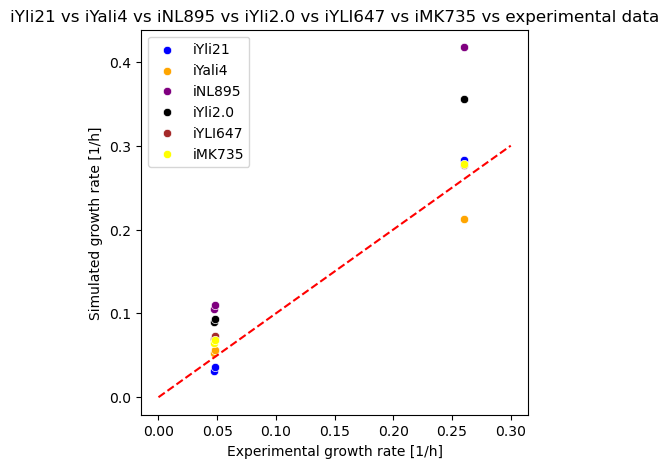

In [24]:
# plot experimental and simulated growth rates

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# plot
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=yli_experimental_growth, y=iYli21_simulation_growth, ax=ax, color='blue', label='iYli21')
sns.scatterplot(x=yli_experimental_growth, y=iYali4_simulation_growth, ax=ax, color='orange', label='iYali4')
sns.scatterplot(x=yli_experimental_growth, y=iNL895_simulation_growth, ax=ax, color='purple', label='iNL895')
sns.scatterplot(x=yli_experimental_growth, y=iyli2_0_simulation_growth, ax=ax, color='black', label='iYli2.0')
sns.scatterplot(x=yli_experimental_growth, y=iyli647_simulation_growth, ax=ax, color='brown', label='iYLI647')
sns.scatterplot(x=yli_experimental_growth, y=iMK735_simulation_growth, ax=ax, color='yellow', label='iMK735')
ax.set_xlabel('Experimental growth rate [1/h]')
ax.set_ylabel('Simulated growth rate [1/h]')
ax.set_title('iYli21 vs iYali4 vs iNL895 vs iYli2.0 vs iYLI647 vs iMK735 vs experimental data')

limit = 0.31
# limit x and y axis
plt.ylim([0, limit])
plt.xlim([0, limit])

# plot diagonal line
x = np.linspace(0, limit, 100)
ax.plot(x, x, color='red', linestyle='--')



# # plot
# fig, ax = plt.subplots(figsize=(5,5))
# sns.scatterplot(x=yli_experimental_growth, y=iYli21_simulation_growth, ax=ax)
# g.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
# ax.set_xlabel('Experimental growth rate [1/h]')
# ax.set_ylabel('Simulated growth rate [1/h]')
# ax.set_title('iYli21')

# # plot diagonal line
# x = np.linspace(0, 0.3, 100)
# ax.plot(x, x, color='red', linestyle='--')

# plt.show()
# plot 1:5 line

### iMT1026v3

In [3]:
# iMT1026: glucose results (ppa_glucose_consumption)
iMT1026_model = cobra.io.read_sbml_model(config['models']['ppa1026v3'])

iMT1026_model.objective = 'growth'


Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_oligoP_v "oligophosphate (5-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_polyP_v "polyphosphate (100-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_v "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_c "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppi_c "Diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_c "H+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pi_c

In [90]:
# check the following reactions for Tom: ['R_ACACT1m', 'R_ACACT10m', 'R_ACACT1'] 
for rxn in iMT1026_model.reactions:
    if 'acetyl-CoA C-acetyltransferase' in rxn.name:
        print(rxn.id, rxn.name, rxn.reaction, rxn.bounds)

# ACACT1m acetyl-CoA C-acetyltransferase, mitochondrial 2.0 accoa_m --> aacoa_m + coa_m (0.0, 1000.0)
accoa_m = iMT1026_model.metabolites.get_by_id('accoa_m')
accoa_m # Acetyl-CoA in mitocondria

aacoa_m = iMT1026_model.metabolites.get_by_id('aacoa_m')
aacoa_m # Acetoacetyl-CoA in mitocondria (participate in 3 reactions: ACACT1m, AACOAT, HMGCOASm)

# coa_m = iMT1026_model.metabolites.get_by_id('coa_m')
# coa_m # CoA in mitocondria

accoa_x = iMT1026_model.metabolites.get_by_id('accoa_x')
accoa_x # Acetyl-CoA in peroxisome 

# ACACT10m acetyl-CoA C-acetyltransferase, mitochondrial 2maacoa_m + coa_m --> accoa_m + ppcoa_m (0.0, 1000.0)
maacoa_m = iMT1026_model.metabolites.get_by_id('2maacoa_m')
maacoa_m # 2-Methylacetoacetyl-CoA in mitocondria (precursor of Acetoacetyl-CoA)

ppcoa_m = iMT1026_model.metabolites.get_by_id('ppcoa_m')
ppcoa_m # Propionyl-CoA in mitocondria Propanoyl-CoA


# ACACT1x acetyl-CoA C-acetyltransferase, mitochondrial aacoa_x + coa_x --> 2.0 accoa_x (0.0, 1000.0)
# => the reverse reaction is present in the peroxisome

# # ACACT1 acetyl-CoA C-acetyltransferase 2.0 accoa_c --> aacoa_c + coa_c (0.0, 1000.0)
# # => similar reaction is also in the cytosol 
# accoa_c = iMT1026_model.metabolites.get_by_id('accoa_c')
# accoa_c # Acetyl-CoA in cytosol

# # ACACT4p acetyl-CoA C-acetyltransferase (octanoyl-CoA), peroxisomal 3odcoa_x + coa_x --> accoa_x + occoa_x (0.0, 1000.0)
# odcoa_x = iMT1026_model.metabolites.get_by_id('3odcoa_x')
# odcoa_x # 3-Oxodecanoyl-CoA in peroxisome

# occoa_x = iMT1026_model.metabolites.get_by_id('occoa_x')
# occoa_x # Octanoyl-CoA in peroxisome

# # ACACT6p acetyl-CoA C-acetyltransferase (dodecanoyl), peroxisomal 3otdcoa_x + coa_x --> accoa_x + ddcacoa_x (0.0, 1000.0)
# otdcoa_x = iMT1026_model.metabolites.get_by_id('3otdcoa_x')
# otdcoa_x # 3-Oxotetradecanoyl-CoA in peroxisome

# ddcacoa_x = iMT1026_model.metabolites.get_by_id('ddcacoa_x')
# ddcacoa_x # Dodecanoyl-CoA in peroxisome

ACACT1m acetyl-CoA C-acetyltransferase, mitochondrial 2.0 accoa_m --> aacoa_m + coa_m (0.0, 1000.0)
ACACT10m acetyl-CoA C-acetyltransferase, mitochondrial 2maacoa_m + coa_m --> accoa_m + ppcoa_m (0.0, 1000.0)
ACACT1x acetyl-CoA C-acetyltransferase, mitochondrial aacoa_x + coa_x --> 2.0 accoa_x (0.0, 1000.0)
ACACT1 acetyl-CoA C-acetyltransferase 2.0 accoa_c --> aacoa_c + coa_c (0.0, 1000.0)
ACACT4p acetyl-CoA C-acetyltransferase (octanoyl-CoA), peroxisomal 3odcoa_x + coa_x --> accoa_x + occoa_x (0.0, 1000.0)
ACACT6p acetyl-CoA C-acetyltransferase (dodecanoyl), peroxisomal 3otdcoa_x + coa_x --> accoa_x + ddcacoa_x (0.0, 1000.0)


<Metabolite ppcoa_m at 0x7f7acdc0bd00>

In [193]:
## check experimental data with downloaded model because results with other model do not match the experimental data
# iMT1026: glucose results (ppa_glucose_consumption)
iMT1026v3_dl_path = config['models']['ppa1026v3_test']
dl_iMT1026_model = cobra.io.read_sbml_model(iMT1026v3_dl_path)

# # check biomass reactions
# for rxn in dl_iMT1026_model.reactions:
#     if 'biomass' in rxn.name.lower():
#         print(rxn.id, rxn.name, rxn.reaction, rxn.bounds)
# # dl_iMT1026_model.objective = 'growth'

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_oligoP_v "oligophosphate (5-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_polyP_v "polyphosphate (100-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_v "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_c "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppi_c "Diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_c "H+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pi_c

In [140]:
# # looking for growth reaction: => id: growth
# for rxn in dl_iMT1026_model.reactions:
#     if 'growth' in rxn.name.lower():
#         print(rxn.id, rxn.name, rxn.reaction, rxn.bounds)

# # check formulas: => formulas exist
# for met in dl_iMT1026_model.metabolites:
#     print(met.id, met.formula) # formulas exist
Ex_glyc = dl_iMT1026_model.reactions.get_by_id('Ex_glyc')
Ex_glyc.bounds = (-1.22, 1000) # Glycerol exchange reaction

# check for default growth
dl_iMT1026_model.summary()

In [151]:
## check reactions: O2, CO2, glycerol # Ex_o2, Ex_co2, Ex_glyc
o2_rxn = dl_iMT1026_model.reactions.get_by_id('Ex_o2')
o2_rxn.bounds = (-1000, 1000) # O2 exchange reaction
o2_rxn # o2_e <=>

<Reaction Ex_o2 at 0x7f7b3f136400>

In [182]:
# dl_iMT1026_model.summary()
Ex_glyc = dl_iMT1026_model.reactions.get_by_id('Ex_glyc')
Ex_glyc.bounds = (-0.13,1000) # Glycerol exchange reaction
dl_iMT1026_model.summary()


Infeasible: None (infeasible).

In [196]:
## check experimental data 
# dl_iMT1026_model.objective = 'Ex_biomass'

# # find glycerol (Ex_glyc) and methanol (Ex_meoh) exchange reactions 
# # for rxn in iMT1026_model.exchanges:
# #     print(rxn.id, rxn.name, rxn.reaction, rxn.bounds)

# set all exchanges to (0,0)

# set bounds to (-1000, 1000)
minimal_media_reactions = ['Ex_nh4', 'Ex_pi', 'Ex_h', 'Ex_o2', 'Ex_so4', 'Ex_fe2', 'Ex_btn', 'Ex_k', 'Ex_h2o', 'Ex_co2']
for rxn_id in minimal_media_reactions:
    rxn = dl_iMT1026_model.reactions.get_by_id(rxn_id)
    rxn.bounds = (-1000, 1000)
carbon_source = 'gylcerol'
biomass_reaction = 'growth'
with dl_iMT1026_model as model:
    print(carbon_source)
    iMT1026_simulation_growth_glyc = []
    # # set condition (carbon source, O2)
    for idx, carbon_uptake in enumerate(ppa_glycerol_uptake):
        print('Carbon uptake: ', carbon_uptake)
        Ex_glyc = model.reactions.get_by_id('Ex_glyc')
        Ex_glyc.bounds = (-carbon_uptake, 1000)
        # Ex_o2 = model.reactions.get_by_id('Ex_o2')
        # Ex_o2.bounds = (ppa_glycerol_o2_uptake[idx], 1000)
        # Ex_co2 = model.reactions.get_by_id('Ex_co2')
        # Ex_co2.bounds = (-1000, ppa_glycerol_co2_production[idx])
        # compute results
        solution = pfba(model)
        objective_value = solution.fluxes[biomass_reaction]
        iMT1026_simulation_growth_glyc.append(objective_value)
        print(f'Growth rate on {carbon_uptake} mmol/h {carbon_source}: {objective_value} 1/h the experimental data is {ppa_experimental_glycerol[idx]} 1/h')

# Ex_glyc = iMT1026_model.reactions.get_by_id('Ex_glyc')
# Ex_glyc.bounds = (-1.07, 1000) # Glycerol exchange reaction
# print(Ex_glyc) # Glycerol exchange reaction

# # default growth: 
# iMT1026_model.summary()

# uptake: 0.58, 0.85, 1.07, 1.52, 1.92, 2.41

# growth_rate (iMT1026v3): 0.02899,  0.0475, 0.0625 # no constraints for O2 and CO2
# publication_iMT1026v3: 0.03,  0.05, 0.065
# experimental: 0.035, 0.050, 0.065

# for rxn in iMT1026_model.exchanges:
#     if rxn.lower_bound < 0:
#         print(rxn.id, rxn.name, rxn.reaction, rxn.bounds)


# Results with oxygen and co2 constraints for glycerol
# Growth rate on 0.58 mmol/h gylcerol: 0.022010566315613822 1/h the experimental data is 0.035 1/h
# Growth rate on 0.85 mmol/h gylcerol: 0.048099670276629064 1/h the experimental data is 0.05 1/h
# Growth rate on 1.07 mmol/h gylcerol: 0.06341292783407607 1/h the experimental data is 0.065 1/h
# Growth rate on 1.52 mmol/h gylcerol: 0.09395458963440513 1/h the experimental data is 0.1 1/h
# Growth rate on 1.92 mmol/h gylcerol: 0.11728290199072086 1/h the experimental data is 0.13 1/h
# Growth rate on 2.41 mmol/h gylcerol: 0.15176860668460662 1/h the experimental data is 0.16 1/h 

# Results without oxygen and co2 constraints for glycerol
# Growth rate on 0.58 mmol/h gylcerol: 0.030156477152673163 1/h the experimental data is 0.035 1/h
# Growth rate on 0.85 mmol/h gylcerol: 0.048481489729063576 1/h the experimental data is 0.05 1/h
# Growth rate on 1.07 mmol/h gylcerol: 0.06341298145786804 1/h the experimental data is 0.065 1/h
# Growth rate on 1.52 mmol/h gylcerol: 0.09395466908510146 1/h the experimental data is 0.1 1/h
# Growth rate on 1.92 mmol/h gylcerol: 0.12110275033978032 1/h the experimental data is 0.13 1/h
# Growth rate on 2.41 mmol/h gylcerol: 0.15435911450238052 1/h the experimental data is 0.16 1/h

# Summary: The constraints of O2 and CO2 does not lead to differences in growth for concentrations uptake rates of 1.07 and 1.52 mmol/h glycerol.
# The other conditions differ slightly. The highest difference is observable for 0.58 mmol/h. The difference in simulation is 0.008 1/h and the results without additional constraints are closer to the experimental data. 

gylcerol
Carbon uptake:  0.58
Growth rate on 0.58 mmol/h gylcerol: 0.030156477152673163 1/h the experimental data is 0.035 1/h
Carbon uptake:  0.85
Growth rate on 0.85 mmol/h gylcerol: 0.048481489729063576 1/h the experimental data is 0.05 1/h
Carbon uptake:  1.07
Growth rate on 1.07 mmol/h gylcerol: 0.06341298145786804 1/h the experimental data is 0.065 1/h
Carbon uptake:  1.52
Growth rate on 1.52 mmol/h gylcerol: 0.09395466908510144 1/h the experimental data is 0.1 1/h
Carbon uptake:  1.92
Growth rate on 1.92 mmol/h gylcerol: 0.12110275033978031 1/h the experimental data is 0.13 1/h
Carbon uptake:  2.41
Growth rate on 2.41 mmol/h gylcerol: 0.15435911450238052 1/h the experimental data is 0.16 1/h


In [4]:
# check model numbers
with iMT1026_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges)) #222 but no external compartment
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])

Reactions:  2237
Metabolites:  1706
Genes:  1026
Exchange:  175
glucose exchange:  ['Ex_glc_D']
biomass reaction:  [('growth', 'Growth'), ('BIOMASS', 'Biomass composition (g/g)'), ('Ex_biomass', 'Biomass exchange'), ('BIOMASS8020', 'Biomass composition 80:20 (g/g)'), ('BIOMASS6040', 'Biomass composition 60:40 (g/g)'), ('BIOMASS4060', 'Biomass composition 40:60 (g/g)'), ('BIOMASS8020b', 'Biomass composition 80:20 (g/g)'), ('BIOMASS6040b', 'Biomass composition 60:40 (g/g)'), ('BIOMASS4060b', 'Biomass composition 40:60 (g/g)'), ('BIOMASS_glyc', 'Biomass composition (g/g)- Glycerol'), ('BIOMASS_meoh', 'Biomass composition (g/g)- Methanol')]


In [63]:
iMT1026_model.summary()

In [59]:
# ## check bounds of glycerol uptake
# Ex_glyc = iMT1026_model.reactions.get_by_id('Ex_glyc')
# Ex_glyc.bounds = (0,1000) # => glyc_e -->
# Ex_glyc

# # check glucose reaction:
# Ex_glc_D = iMT1026_model.reactions.get_by_id('Ex_glc_D')
# Ex_glc_D

# ## check bounds of biomass reaction
# biomass = iMT1026_model.reactions.get_by_id('Ex_biomass')
# biomass


<Reaction Ex_glc_D at 0x7f7b2c8a5340>

In [64]:
glucose_exchange_reaction = 'Ex_glc_D'
iMT1026_biomass = 'growth'
iMT1026_o2 = 'Ex_o2'
# # chech media:
# iMT1026_model.medium

glyc_rxn = iMT1026_model.reactions.get_by_id('Ex_glyc')
glyc_rxn.bounds = (0, 1000)

# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
iMT1026_simulation_growth = []
# iterate over array with index:
for idx, condition in enumerate(ppa_glucose_consumption):
    # with iyli647_model as model:
    #     dGlu = model.reactions.get_by_id(glucose_exchange_reaction)
    #     dGlu.bounds = (-condition, 1000)
    #     try:
    #         pfba_solution = pfba(model)
    #         growthRate = pfba_solution.fluxes[biomass_reaction]
    #     except:
    #         growthRate = 0
    #     iyli647_simulation_growth.append(growthRate)
    #     print(f'Growth rate on {condition} mmol/h glucose: {growthRate}')
    with iMT1026_model as model:
        oxygen_condition = ppa_oxygen_concentration[idx]
        dGlu = model.reactions.get_by_id(glucose_exchange_reaction)
        dGlu.bounds = (-condition, 1000)
        if oxygen_condition == 'hypoxic':
            dO2 = model.reactions.get_by_id(iMT1026_o2)
            dO2.bounds = (-2.01, 0)
        else:
            dO2 = model.reactions.get_by_id(iMT1026_o2)
            dO2.bounds = (-2.35, 0)
        # sol = model.optimize()
        iMT1026_pfba_solution = pfba(model)
        iMT1026_simulation_growth.append(iMT1026_pfba_solution.fluxes.Ex_biomass)
        print(f'Growth rate on {condition} mmol/h glucose: {iMT1026_pfba_solution.fluxes.Ex_biomass}')



Growth rate on 1.0 mmol/h glucose: 0.1082861973914887
Growth rate on 1.72 mmol/h glucose: 0.11604867570480527


In [166]:
with iMT1026_model:
    dGlu = iMT1026_model.reactions.get_by_id(glucose_exchange_reaction)
    dGlu.bounds = (-2.43, 1000)
    ## check bounds of glucose uptake
    glucose = iMT1026_model.reactions.get_by_id('Ex_glc_D')
dGlu

<Reaction Ex_glc_D at 0x7f9b1082b2b0>

In [ ]:
for rxn in iMT1026_model.exchanges:
    if rxn.lower_bound < 0:
        print(rxn.id, rxn.name, rxn.bounds)

Ex_h2o H2O exchange (-1000.0, 1000.0)
Ex_nh4 Ammonium exchange (-1000.0, 0.0)
Ex_pi Phosphate exchange (-1000.0, 0.0)
Ex_h H+ exchange (-1000.0, 1000.0)
Ex_o2 Oxygen exchange (-1000.0, 0.0)
Ex_so4 Sulfate exchange (-1000.0, 0.0)
Ex_fe2 Fe2+ exchange (-1000.0, 0.0)
Ex_btn Biotin exchange (-4e-05, 0.0)
Ex_k potassium exchange (-1000.0, 1000.0)


### iMT1026 2016

#### Load real model (slow)

In [33]:
# load model
iMT1026v1_model_path = config['models']['ppa1026']
iMT1026v1_model = cobra.io.read_sbml_model(iMT1026v1_model_path)
# set objective to BIOMASS
iMT1026v1_model.objective = 'BIOMASS'


Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
urn:miriam:taxonomy:4922 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
urn:miriam:chebi:16529 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
urn:miriam: kegg.compound:C02174 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_oligoP_v "oligophosphate (5-P)">
urn:miriam:chebi:16838 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
urn:miriam: kegg.compound:C00404 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
Use of F

In [34]:
# write the model to a file it is loading much faster
cobra.io.write_sbml_model(iMT1026v1_model, 'iMT1026v1.xml')

#### Load written model (fast)

In [3]:
# read again
iMT1026v1_model = cobra.io.read_sbml_model('iMT1026v1.xml')
# set objective to BIOMASS
iMT1026v1_model.objective = 'BIOMASS'

# check comparments
iMT1026v1_model.compartments

{'C_v': 'Vacuole',
 'C_c': 'Cytosol',
 'C_m': 'Mitochondria',
 'C_x': 'Peroxisome',
 'C_e': 'Extracellular space',
 'C_r': 'Endoplasmic Reticulum',
 'C_g': 'Golgi Apparatus',
 'C_n': 'Nucleus',
 'C_i': 'Mitochondrial intermembrane space'}

In [12]:
with iMT1026v1_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges)) #222 but no external compartment
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Reactions:  2210
Metabolites:  2755
Genes:  0
Exchange:  175
glucose exchange:  ['Ex_glc_D']
biomass reaction:  [('growth', 'Growth'), ('BIOMASS', 'Biomass composition (g/g)'), ('Ex_biomass', 'Biomass exchange'), ('BIOMASS8020', 'Biomass composition 80:20 (g/g)'), ('BIOMASS6040', 'Biomass composition 60:40 (g/g)'), ('BIOMASS4060', 'Biomass composition 40:60 (g/g)'), ('BIOMASS8020b', 'Biomass composition 80:20 (g/g)'), ('BIOMASS6040b', 'Biomass composition 60:40 (g/g)'), ('BIOMASS4060b', 'Biomass composition 40:60 (g/g)')]


Investigate the metabolites and try to find genes in this set of objects

Summary: Set of metabolties includes the genes (id: E_) (search for E_[1-9] to find all 1026 genes)

In [51]:
# for met in iMT1026v1_model.metabolites:
#     print(met.id, met.name, met.compartment)

# ## Summary: Set of metabolties includes the genes (id: E_) (search for E_[1-9] to find all 1026 genes)

In [28]:
# check the model summary
iMT1026v1_model.summary()

Non-linear or non-reaction model objective. Falling back to minimal display.


### iLC915

In [22]:
# load iLC915 model
iLC915_model_path = config['models']['ppaiLC915']
iLC915_model = cobra.io.read_sbml_model(iLC915_model_path)
# fructose: r1144
# glucose: r1145
# biomass: r1133

# summary: In dem model sind (exchange) Reaktionen aktiv, die nicht richtig in den exchange reaktionen enthalten sind, (growth on glucose: 75.516)

In [17]:
## use the procedure explained in iMT1026 (NOT working -> )
# # set all of these reactions to 0 upper and lower bound
# problematic_rxns = ['r66','r910','r1104','r239','r111','r106','r490','r791','r243','r252','r253','r307','r308','r404','r405','r1320','r639','r640','r641','r642','r649','r650','r651','r652','r645','r646','r643','r644','r653','r654','r655','r656','r534']
# for rxn_id in problematic_rxns:
#     rxn = iLC915_model.reactions.get_by_id(rxn_id)
#     rxn.bounds = (0,0)

# # glu_rxn = iLC915_model.reactions.get_by_id('r1145')
# # glu_rxn.bounds = (-1, 1000)


In [14]:
iLC915_model.summary()

In [6]:
# check model numbers
with iLC915_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges)) #222 but no external compartment
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])

Reactions:  1423
Metabolites:  1303
Genes:  915
Exchange:  54
glucose exchange:  ['r1145']
biomass reaction:  [('r1339', 'Growth'), ('r1133', 'Drain of biomass'), ('r1090', 'Biomass (g/gDW)'), ('r1187', 'Biomass formation')]


In [145]:
def prepare_iLC915_model(model):
    """Gets the model and prepares it for the simulation.
    - Remove every unnecessary reaction
    - Setup the minimal medium
    - Setup Glucose uptake
    """
    # remove all reactions
    for rxn in iLC915_model.exchanges:
        rxn.bounds = (0,0)
    
    for rxn in iLC915_model.boundary:
        rxn.bounds = (0,0)

    # setup the important reactions (H2O, Sulfate, Fe2+, NH3, Orthophosphate)
    min_medium_boundary = ['r1150', 'r1169', 'r1142', 'r1159', 'r1164']
    
    # limit as given in the experimental data
    oxygen = ['r1160']

    # replace (0,0) bounds with (0,1000) bounds to allow growth
    biomass = ['r1133']

    # glucose as carbon source 
    glucose = ['r1145'] 
    glu_uptake = 1 # experimental: 1 and 1.72 mmol/h
    # allow growth: 
    for rxn in iLC915_model.exchanges:
        if rxn.id in min_medium_boundary:
            rxn.bounds = (-1000, 1000)
        elif rxn.id in oxygen:
            rxn.bounds = (-1000, 2.35)
        elif rxn.id in biomass:
            rxn.bounds = (0,1000)
        elif rxn.id in glucose:
            rxn.bounds = (0,glu_uptake)

In [23]:
# prepare the model in order to allow growth
prepare_iLC915_model(iLC915_model)
# Set glucose reaction to -2.43 mmol/h, 0.64 and 0.61 (based on Guo et al. 2022)
iLC915_biomass_reaction = "r1133"
iLC915_glucose_exchange_reaction = 'r1145' # glucose uptake
iLC915_o2 = 'r1160'
iLC915_simulation_growth = []
# iterate over array with index:
for idx, condition in enumerate(ppa_glucose_consumption):
    with iLC915_model:
        oxygen_condition = ppa_oxygen_concentration[idx]
        dGlu = iLC915_model.reactions.get_by_id(iLC915_glucose_exchange_reaction)
        dGlu.bounds = (0, condition)
        if oxygen_condition == 'hypoxic':
            dO2 = iLC915_model.reactions.get_by_id(iLC915_o2)
            dO2.bounds = (0, 2.01)
        else:
            dO2 = iLC915_model.reactions.get_by_id(iLC915_o2)
            dO2.bounds = (0, 2.35)
        sol = iLC915_model.optimize()
        # iLC915_objective_value = sol.objective_value
        iLC915_pfba_solution = pfba(iLC915_model)
        iLC915_objective_value = iLC915_pfba_solution.fluxes[iLC915_biomass_reaction]
        iLC915_simulation_growth.append(iLC915_objective_value)
        print(f'Growth rate on {condition} mmol/h glucose: {iLC915_objective_value}')

Growth rate on 1.0 mmol/h glucose: 0.048582120352767294
Growth rate on 1.72 mmol/h glucose: 0.041820955428763955


#### Get the model working
#### Summary what I did:
- default growth? -> Yes, but growth rate way too high
- compute minimal media (this was not actually minimal and setting this lead again to zero growth)
- Analyzed the media reactions and compounds
- Found that setting the reaction's upper bounds was working, but did not understand why this was the case
- Thought the amino acids are neccessary
##### Found the reaction Ids which were needed for growth according to iMT1026 (H2O, Oxygen, ...)
- Compared zero growth and default growth reactions (as objects) 
- I was able to restore the growth after it was gone with the bounds I stored
- Analyzed the uptake_flux part of the summary element (Leads to insights about what was utilized by the model) 
- Found out that there are some reactions in the boundary reaction set but are not in the exchange reactions. Do not understand why (e.g. r1152 - myo-inositol)
- Step by step analysis of the growth related reactions (knock-in and optimize)
- found out, that the definition of their uptake reactions were the other way around that I knew it -> I have to set the bounds differently
- analyse default definition of biomass, glucose uptake reaction
- setting glucose and biomass bounds (hopefully) correctly
- integrating the result into the plot

In [ ]:
# default growth
iLC915_model.optimize()

In [44]:
# ### compute minimal media
# iLC_min_medium = minimal_medium(iLC915_model)
# # iLC_min_medium = minimal_medium(iLC915_model, min_objective_value=0.5, minimize_components=True, open_exchanges=True)
# iLC_min_medium
# min_media_list = list(iLC_min_medium.index)

In [43]:
## Analyzed medium and set of exchange reactions I thought responsible for the growth
# hf.mediumAnalysis(iLC915_model)

# # uptake reactions:
# for rxn in iLC915_model.exchanges:
#     if rxn.lower_bound < 0:
#         print(rxn.id, rxn.name, rxn.bounds)

# # not needed: r1149 (glycin), r1141 (ethoanol)
# iLC915_not_needed = ['r1149', 'r1141']
# for rxn_id in iLC915_not_needed:
#     rxn = iLC915_model.reactions.get_by_id(rxn_id)
#     rxn.bounds = (0, 0)

# # Set glucose reaction to -1.0 mmol/h 
# iLC_glu = iLC915_model.reactions.get_by_id('r1145')
# iLC_glu.bounds = (-1.0, 1000)
# iLC915_model.optimize()

# ## trying to understand which production reactions are used for ATP synthesis
# # for met in iLC915_model.metabolites:
# #     if 'atp' in met.name.lower():
# #         print(met.id, met.name, met.compartment) #m1 cytosolic

# # iLC915_model.metabolites.m1.summary()

In [14]:
# ## analyse minimal medium
# for rxn_id in min_media_list:
#     rxn = iLC915_model.reactions.get_by_id(rxn_id)
#     print(rxn.id, rxn.name, [met.name for met in list(rxn.metabolites)], rxn.bounds)
# # => amino acids seem to be necessary

# print(iLC915_model.medium)
# for rxn in iLC915_model.exchanges:
#     rxn.bounds = (0, 0)
# print(iLC915_model.medium)
# iLC915_model.reactions.get_by_id('r1145').bounds = (-20, 1000)
# iLC915_model.reactions.get_by_id('r1169').bounds = (-20, 1000)
# iLC915_model.reactions.get_by_id('r1139').bounds = (-20, 1000)
# iLC915_model.reactions.get_by_id('r1160').bounds = (-20, 1000)
# print(iLC915_model.medium)

# iLC915_model.summary()


r1157 L-Methionine uptake or drain ['L-Methionine_C5H11NO2S'] (-1000.0, 1000.0)
r1173 Uptake of alpha,alpha-Trehalose ['alpha,alpha-Trehalose_C12H22O11'] (0.0, 1000.0)


Found the reaction Ids which were needed for growth according to iMT1026 (H2O, Oxygen, ...)

In [33]:
# prepare growth condition
# all exchange reactions to Zero
# print('All exchange reactions to Zero')
for rxn in iLC915_model.exchanges:
    if rxn.upper_bound > 0:
        print(rxn.id, rxn.name, rxn.bounds)
    rxn.bounds = (0,0)
# print(iLC915_model.medium)

# all boundary reactions to zero
for rxn in iLC915_model.boundary:
    rxn.bounds = (0,0)

min_medium_boundary = ['r1150', 'r1169', 'r1142', 'r1159', 'r1164']# r1159, r1164
biotin = ['r1132'] # limit to 0.00004 mmol/h
oxygen = ['r1160'] # limit to -2.35 mmol/h
biomass = ['r1133']

# amino_acids = ['r1129', 'r1151', 'r1157', 'r1163', 'r1173', 'r1175', 'r1176'] # old
amino_acids = ['r1126', 'r1129', 'r1130', 'r1131', 'r1139', 'r1140', 'r1146', 'r1147', 'r1151', 'r1153', 'r1154', 'r1155', 'r1157', 'r1162', 'r1163', 'r1165', 'r1168', 'r1174', 'r1175', 'r1176', 'r1178'] # new and hopefully comprehensive

glucose = ['r1145'] # -1 mmol/h
glu_uptake = 1 # and 1.72


not_amino = ['r1141', 'r1149', 'r1150']
print('Size of exchange reactions before loop ', len(iLC915_model.exchanges))
for rxn in iLC915_model.exchanges:
    if rxn.id in min_medium_boundary:
        rxn.bounds = (-1000, 1000)
    elif rxn.id in oxygen:
        rxn.bounds = (-1000, 2.35)
    elif rxn.id in biomass:
        rxn.bounds = (0,1000)
    # if rxn.id in biotin:
    #     rxn.bounds = (-0.1, 1000)
    # elif rxn.id in amino_acids:
    #     rxn.bounds = (-0.1, 0.1)
    elif rxn.id in glucose:
        rxn.bounds = (0,glu_uptake)
    # elif rxn.id in not_amino:
    #     rxn.bounds = (-100,100)

# print(iLC915_model.medium)
# for rxn in iLC915_model.exchanges:
#     if rxn.lower_bound < 0:
#         print(rxn.id, rxn.name, rxn.bounds)

# print('All exchange reactions:')
# for rxn in iLC915_model.exchanges:
#     print(rxn.id, rxn.name, rxn.bounds)

# sol = pfba(iLC915_model)
# sol.fluxes.r1133
iLC915_model.optimize()
# h2o (r1150), ammonium (id: r1159) , phosphate (r1164), h+, oxygen (r1160), sulfate (r1169), fe2 (r1142), biotin (-4e-05) (r1132), potassium


r1133 Drain of biomass (0, 1000)
r1142 Uptake of Fe2+ (-1000, 1000)
r1145 Uptake of alpha-D-Glucose (0, 1)
r1150 Drain of H2O (-1000, 1000)
r1159 Uptake of NH3 (-1000, 1000)
r1160 uptake of O2 (-1000, 2.35)
r1164 Uptake of Orthophosphate (-1000, 1000)
r1169 Uptake of Sulfate (-1000, 1000)
Size of exchange reactions before loop  54


<Solution 0.049 at 0x7f9fd87f91f0>

In [34]:
# ### last attempt: compare the media composition of the two models
# zero_growth = {'r1129': 1000, 'r1132': 1000, 'r1142': 1000, 'r1145': 1000, 'r1150': 1000, 'r1151': 1000, 'r1157': 1000, 'r1159': 1000, 'r1160': 1000, 'r1163': 1000, 'r1164': 1000, 'r1169': 1000, 'r1173': 1000, 'r1175': 1000, 'r1176': 1000}

# default_growth = {'r1122': 1000.0, 'r1123': 1000.0, 'r1124': 1000.0, 'r1125': 1000.0, 'r1126': 1000.0, 'r1127': 1000.0, 'r1129': 1000.0, 'r1130': 1000.0, 'r1131': 1000.0, 'r1132': 1000.0, 'r1135': 1000.0, 'r1136': 1000.0, 'r1139': 1000.0, 'r1140': 1000.0, 'r1141': 1000.0, 'r1142': 1000.0, 'r1143': 1000.0, 'r1144': 1000.0, 'r1145': 1000.0, 'r1146': 1000.0, 'r1147': 1000.0, 'r1148': 1000.0, 'r1149': 1000.0, 'r1150': 1000.0, 'r1151': 1000.0, 'r1153': 1000.0, 'r1154': 1000.0, 'r1155': 1000.0, 'r1156': 1000.0, 'r1157': 1000.0, 'r1158': 1000.0, 'r1159': 1000.0, 'r1160': 1000.0, 'r1161': 1000.0, 'r1162': 1000.0, 'r1163': 1000.0, 'r1164': 1000.0, 'r1165': 1000.0, 'r1167': 1000.0, 'r1168': 1000.0, 'r1169': 1000.0, 'r1170': 1000.0, 'r1171': 1000.0, 'r1172': 1000.0, 'r1173': 1000.0, 'r1174': 1000.0, 'r1175': 1000.0, 'r1176': 1000.0, 'r1178': 1000.0}

# zero_growth_key = list(zero_growth.keys())
# print(len(zero_growth_key)) # 15

# default_growth_key = list(default_growth.keys())
# print(len(default_growth_key)) #49

# # not included in zero_growth
# not_in_zero_growth = []
# for rxn_id in default_growth:
#     if rxn_id not in zero_growth_key:
#         not_in_zero_growth.append(rxn_id)

# print(len(not_in_zero_growth)) # 34
# for rxn_id in not_in_zero_growth:
#     rxn = iLC915_model.reactions.get_by_id(rxn_id)
#     print(rxn_id, rxn.name, rxn.bounds, list(rxn.metabolites)[0])

In [35]:
# ## Storing the bounds of reactions from the default model
# growth_bounds = {rxn.id: rxn.bounds for rxn in iLC915_model.exchanges if rxn.upper_bound > 0 and not rxn.lower_bound < 0}

# ## restore growth
# for rxn_id, bounds in growth_bounds.items():
#     rxn = iLC915_model.reactions.get_by_id(rxn_id)
#     rxn.bounds = bounds

# iLC915_model.optimize()

In [36]:
# # analyse the uptake df (reactions with flux != 0) -> print name of reaction
# summary_dict = iLC915_model.summary()
# uptake_df = summary_dict.uptake_flux
# uptake_df.head()

# # iLC915_model.metabolites.m2
# non_zero_flux = uptake_df[uptake_df.flux != 0]
# len(non_zero_flux) # 21
# for rxn_id in non_zero_flux.index:
#     rxn = iLC915_model.reactions.get_by_id(rxn_id)
#     # rxn.lower_bound = 0
#     print(rxn.id, rxn.name, rxn.bounds)

In [37]:
# ## Found out that the reactions are defined differently
# # print(iLC915_model.medium)

# # iLC915_model.optimize()
# print(len(iLC915_model.boundary)) # 58
# print(len(iLC915_model.exchanges)) # 54

# # check bounds of biomass reaction
# biomass = iLC915_model.reactions.get_by_id('r1133')
# biomass

# biomass_met = iLC915_model.metabolites.get_by_id('m1226')
# biomass_met

# # orther reaction = r1339
# r1339 = iLC915_model.reactions.get_by_id('r1339')
# r1339

In [38]:
# ## check min medium boundary
# for rxn in iLC915_model.exchanges:
#     if rxn.id in min_medium_boundary:
#         print(rxn.id, rxn.name, rxn.bounds)
# # => no carbon source

# r1133 = iLC915_model.reactions.get_by_id('r1133')
# r1133 # drain of biomass

# # ## check model.summary()
# with iLC915_model as model:
#     sol = model.optimize()
#     print(sol.objective_value)
#     print(model.summary())

In [39]:
# ### check metabolites of summary (random flux through r1152)
# mets_of_interest= ['m897', 'm1231', 'm1232', 'm1233']
# for met_id in mets_of_interest:
#     met = iLC915_model.metabolites.get_by_id(met_id)
#     print(met.id, met.name, met.compartment)
# r1145 = iLC915_model.reactions.get_by_id('r1145')
# r1145 # glucose uptake
# r1152 = iLC915_model.reactions.get_by_id('r1152')
# r1152 # uptake of amino acids

In [40]:
## Analysis of the metabolites and reactions
# m30 = iLC915_model.metabolites.get_by_id('m30')
# m30 #H2O is secreted

# # m1232: uptake with 444.5 flux
# m1232 = iLC915_model.metabolites.get_by_id('m1232')
# m1232 # O2 is consumed (?) it has positive flux

# r1160 = iLC915_model.reactions.get_by_id('r1160')
# r1160 # O2 uptake

# r1145 = iLC915_model.reactions.get_by_id('r1145')
# r1145 # glucose uptake

# m1231 = iLC915_model.metabolites.get_by_id('m1231')
# m1231 # NH3

# m1232 = iLC915_model.metabolites.get_by_id('m1232')
# m1232 # Oxygen

# m1233 = iLC915_model.metabolites.get_by_id('m1233')
# m1233 # Sulfate

# m30 = iLC915_model.metabolites.get_by_id('m30')
# m30 # H2O

In [41]:
# analyse step by step the reactions which are active while growth is predicted
# # add one reaction at a time and analyse the result
# for rxn_id, bounds in growth_bounds.items():
#     with iLC915_model as model:
#         print(rxn_id)
#         rxn = model.reactions.get_by_id(rxn_id)
#         rxn.bounds = bounds
#         print(model.optimize())
    

In [42]:
# ## tmp file for reaction and metabolite checking
# # all
# ['r1126', 'r1129', 'r1130', 'r1131', 'r1139', 'r1140', 'r1141', 'r1146', 'r1147', 'r1149', 'r1150', 'r1151', 'r1153', 'r1154', 'r1155', 'r1157', 'r1162', 'r1163', 'r1165', 'r1168', 'r1174', 'r1175', 'r1176', 'r1178']

# ## amino acids 
# ['r1126', 'r1129', 'r1130', 'r1131', 'r1139', 'r1140', 'r1146', 'r1147', 'r1151', 'r1153', 'r1154', 'r1155', 'r1157', 'r1162', 'r1163', 'r1165', 'r1168', 'r1174', 'r1175', 'r1176', 'r1178'] # new and hopefully comprehensive

# ## not amino acids 
# ['r1141', 'r1149', 'r1150']
# r1141 Ethanol uptake or drain (-1000.0, 1000.0)
# r1149 Glycine uptake or drain (-1000.0, 1000.0)
# r1150 Drain of H2O (-1000.0, 1000.0)

# ## model summary
#  m897    r1152 0.0001194         0  0.00% # inisitol
# m1231    r1159     1.768         0  0.00%
# m1232    r1160      2.35         0  0.00%
# m1233    r1169 0.0009794         0  0.00%
# # metabolites:
# ['m897', 'm1231', 'm1232', 'm1233']

### MBEL1254 (failed)

In [70]:
MBEL1254_model_path = config['models']['ppaMBEL1254']
MBEL1254_model = cobra.io.read_sbml_model(MBEL1254_model_path)

Model does not contain SBML fbc package information.
'' is not a valid SBML 'SId'.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Adding exchange reaction EX_star_e with default bounds for boundary metabolite: star_e.
Adding exchange reaction EX_pheL_e with default bounds for boundary metabolite: pheL_e.
Adding exchange reaction EX_a_2mbald_e with default bounds for boundary metabolite: a_2mbald_e.
Adding exchange reaction EX_c161_e with default bounds for boundary metabolite: c161_e.
Adding exchange reaction EX_csn_e with default bounds for boundary metabolite: csn_e.
Adding exchange reaction EX_fmn_e with default bounds for boundary metabolite: fmn_e.
Adding exchange reaction EX_pyr_e with default bounds for boundary metabolite: pyr_e.
Adding exchange reaction EX_crn_e with default bounds for boundary metabolite: crn_e.
Adding exchange reaction EX_fecost_e with default bounds for boun

In [14]:
# check model numbers
with MBEL1254_model as model:
    print('Reactions: ', len(model.reactions))
    print('Metabolites: ', len(model.metabolites))
    print('Genes: ', len(model.genes))
    print('Exchange: ', len(model.exchanges))
    print('glucose exchange: ', [r.id for r in model.exchanges if 'glucose' in r.name.lower()])
    print('biomass reaction: ', [(r.id, r.name) for r in model.reactions if 'biomass' in r.name.lower() or 'growth' in r.name.lower()])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Reactions:  1412
Metabolites:  1216
Genes:  0
Exchange:  158
glucose exchange:  []
biomass reaction:  [('EX_Biomass', 'EX_Biomass')]


In [71]:
MBEL1254_model.objective = 'EX_Biomass'

MBEL1254_model.summary()

In [73]:
# ## default growth 
# MBEL1254_model.summary()

# # find glucose reaction: EX_glcD_e
# hf.mediumAnalysis(MBEL1254_model)

# # find biomass reaction: EX_Biomass
# for rxn in MBEL1254_model.reactions:
#     if 'biomass' in rxn.name.lower() or 'growth' in rxn.name.lower():
#         print(rxn.id, rxn.name)

MBEL1254_glucose = MBEL1254_model.reactions.get_by_id('EX_glcD_e') # glcD_e <=>
MBEL1254_biomass = MBEL1254_model.reactions.get_by_id('EX_Biomass') # Biomass <=> (default bounds: (-1000, 1000))
MBEL1254_biomass.bounds = (-1000,0)

MBEL1254_min_media = ['EX_H2O_e', 'EX_nh4_e',  'EX_pi_e', 'EX_h_e', 'EX_O2_e', 'EX_so4_e', 'EX_fe2_e', 'EX_k_e']

# checke die exchange reactions zwei tests 27 und 53 (e.g. fecostest_e <=>) => negative flux is needed for uptake
for rxn in MBEL1254_model.exchanges:
    rxn.bounds = (0,1000)
    # if rxn.id not in MBEL1254_min_media:
    #     print(rxn.reaction)

# boundaries = [rxn.id for rxn in MBEL1254_model.boundary]
# exchanges = [rxn.id for rxn in MBEL1254_model.exchanges]
# boundaries.sort()
# exchanges.sort()
# print('Boundary and Exchange are the same!: ', boundaries == exchanges) #True

for rxn in MBEL1254_min_media:
    MBEL1254_model.reactions.get_by_id(rxn).bounds = (-1000,1000)

EX_glcD_e = MBEL1254_model.reactions.get_by_id('EX_glcD_e')
EX_glcD_e.bounds = (0,0)

# MBEL1254_biomass.bounds = (-1000,0)
print(MBEL1254_biomass.reaction)
print('biomass bounds: ', MBEL1254_biomass.bounds)

# # # check if growth is predicted
summary_res = MBEL1254_model.summary()

# for rxn_id in summary_res.uptake_flux['reaction'].to_list():
#     print(rxn_id, MBEL1254_model.reactions.get_by_id(rxn_id).name)
MBEL1254_model.summary()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Biomass --> 
biomass bounds:  (0, 1000)


In [73]:
default_secretion_reaction = ["EX_Biomass", "EX_ade_e", "EX_c160_e", "EX_c180_e", "EX_c181_e", "EX_chol_e", "EX_dttp_e", "EX_g3pc_e", "EX_pi_e", "EX_pntoR_e", "EX_so3_e", "EX_sprm_e"]

# for rxn_id in default_secretion_reaction:
#     rxn = MBEL1254_model.reactions.get_by_id(rxn_id)
#     print(rxn.id, rxn.reaction, rxn.bounds)
EX_nh4_e = MBEL1254_model.reactions.get_by_id('EX_nh4_e')
EX_nh4_e.bounds = (0,1000)
EX_H2O_e = MBEL1254_model.reactions.get_by_id('EX_H2O_e')
EX_H2O_e.bounds = (0,1000)
EX_so4_e = MBEL1254_model.reactions.get_by_id('EX_so4_e')
EX_so4_e.bounds = (0,1000)
EX_fe2_e = MBEL1254_model.reactions.get_by_id('EX_fe2_e')
EX_fe2_e.bounds = (0,1000)
EX_k_e = MBEL1254_model.reactions.get_by_id('EX_k_e')
EX_k_e.bounds = (0,1000)
EX_pi_e = MBEL1254_model.reactions.get_by_id('EX_pi_e')
EX_pi_e.bounds = (0,1000)
EX_h_e = MBEL1254_model.reactions.get_by_id('EX_h_e')
EX_h_e.bounds = (0,1000)
EX_O2_e = MBEL1254_model.reactions.get_by_id('EX_O2_e')
EX_O2_e.bounds = (0,1000)
for rxn in MBEL1254_model.exchanges:
    if "<=>" in rxn.reaction:
        print(rxn.id, rxn.reaction, rxn.bounds)



Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [74]:
# ## default growth 
MBEL1254_model.summary()

# # # check medium
# # print(MBEL1254_model.medium) # -> pretty long and compartment error
# # encountered compartment error
# # -> check compartments
# print(MBEL1254_model.compartments)
# # -> only one compartment in this model (called: 'cell')

# # # check medium in more depth
# hf.mediumAnalysis(MBEL1254_model)
# # # => every exchange reaction's bound is set to (-1000,1000) -> there should be growth

# # checking the model boundary
# for rxn in MBEL1254_model.boundary:
#     print(rxn.id, rxn.name, rxn.bounds)

# # check if boundary and exchange reaction set are the same
# boundary_list = [rxn.id for rxn in MBEL1254_model.boundary]
# boundary_list.sort()
# # print(boundary_list)
# exchange_list = [rxn.id for rxn in MBEL1254_model.exchanges]
# exchange_list.sort()
# # print(exchange_list)
# print(f'boundary and exchange reaction set are the same: {boundary_list == exchange_list}') # True

# print(len(MBEL1254_model.boundary)) # 158
# print(len(MBEL1254_model.exchanges)) # 158

# iterate over exchange reactions and check the names with phosphate
# for rxn in MBEL1254_model.exchanges:
#     met_name = list(rxn.metabolites.keys())[0].name
#     print(met_name)
    # if 'pho' in met_name.lower():
    #     print(rxn.id, rxn.name, rxn.bounds)

# # do the metabolites have names? -> No the metabotites have no names
# ex_reaction = MBEL1254_model.exchanges[23]
# ex_reaction
# mets = list(ex_reaction.metabolites.keys())
# met = mets[0]
# met

# no objective reaction is set

# # find growth / biomass reaction
# for rxn in MBEL1254_model.reactions:
#     if 'biomass' in rxn.id.lower():
#         print(rxn.id, rxn.name, rxn.bounds) # EX_Biomass

# # set biomass reaction as objective
# MBEL1254_model.objective = 'EX_Biomass'

# # # check optimization result
# # MBEL1254_model.optimize() # growth 1000 because everything is allowed to be exchanged

# # find the reactions for (H2O, Ammonium, Phosphate, H+, Oxygen (EX_O2_e), Sulfate, Fe2+, Biotin, potassium (EX_k_e)) CO2 (EX_CO2_e)
# MBEL1254_min_media = ['EX_H2O_e', 'EX_nh4_e',  'EX_pi_e', 'EX_h_e', 'EX_O2_e', 'EX_so4_e', 'EX_fe2_e', 'EX_k_e']

# # # build different groups of the uptake reactions in order to find improtant reactions
# group1 = ['EX_CO2_e', 'EX_akg_e', 'EX_alltn_e', 'EX_dttp_e', 'EX_gcald_e', 'EX_h_e', 'EX_inost_e', 'EX_lanost_e', 'EX_nadp_e']
# group2 = ['EX_orn_e', 'EX_ptd1ino_e', 'EX_ptrc_e', 'EX_star_e', 'EX_thm_e', 'EX_tre_e', 'EX_ura_e', 'EX_xan_e', 'EX_xtsn_e']

# # set everything to 0
# # e.g.: star_e <--
# for rxn in MBEL1254_model.boundary:
#     rxn.bounds = (-1000,100)

# myNumber = 7
# counter = 1
# # star_e <--
# for rxn in MBEL1254_model.exchanges:
#     counter += 1
#     rxn.bounds = (-1000,100)
#     if counter == myNumber:
#         rxn.bounds = (-10,645)

# # set minimal media to (-1000,1000)
# for rxn_id in MBEL1254_min_media:
#     rxn = MBEL1254_model.reactions.get_by_id(rxn_id)
#     rxn.bounds = (-1000,1000)

# # set group1 to (-1,1000)
# for rxn_id in group1:
#     rxn = MBEL1254_model.reactions.get_by_id(rxn_id)
#     rxn.bounds = (-1000,1000)

# for rxn_id in group2:
#     rxn = MBEL1254_model.reactions.get_by_id(rxn_id)
#     rxn.bounds = (-1000,1000)

# # find carbon sources: glucose (EX_glcD_e), glycin (EX_gly_e), Glyoxylate (EX_glx_e)
# EX_glcD_e = MBEL1254_model.reactions.get_by_id('EX_glcD_e')
# EX_glcD_e.bounds = (0,1)

# # analyse biomass and set the right bounds
# biomass = MBEL1254_model.reactions.get_by_id('EX_Biomass')
# biomass.bounds = (-1000, 0)

# # check optimization result
# MBEL1254_model.optimize()

# # summary:
# MBEL1254_model.summary()

# # # # reactions are defined in a weird way (g3pc_e <--)
# # EX_g3pc_e = MBEL1254_model.reactions.get_by_id('EX_g3pc_e')
# # EX_g3pc_e

# # # glucose (glcD_e <=>)
# # EX_glcD_e = MBEL1254_model.reactions.get_by_id('EX_glcD_e')
# # EX_glcD_e

# # hf.mediumAnalysis(MBEL1254_model)


### Visalize for Pichia pastoris

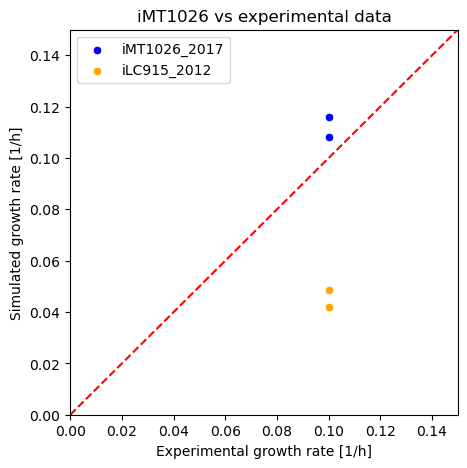

In [69]:
# plot experimental and simulated growth rates for the model iMT1026v3 and iLC915 respectively

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# plot
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=ppa_experimental_growth, y=iMT1026_simulation_growth, ax=ax, color='blue', label='iMT1026v3_2017')
sns.scatterplot(x=ppa_experimental_growth, y=iLC915_simulation_growth, ax=ax, color='orange', label='iLC915_2012')
ax.set_xlabel('Experimental growth rate [1/h]')
ax.set_ylabel('Simulated growth rate [1/h]')
ax.set_title('iMT1026v3 vs iLC915 vs experimental data')

limit = 0.15
# limit x and y axis
plt.ylim([0, limit])
plt.xlim([0, limit])

# plot diagonal line
x = np.linspace(0, limit, 100)
ax.plot(x, x, color='red', linestyle='--')

### Compartment error
Look into bigg model of E. coli

In [ ]:
# load ecoli model
'None'

## Simulation of glucose and oxygen data


- load models
- set all carbons to zero
- get the reactions (glucose, glycerol, oxygen, biomass, CO2)
- set the bounds accordingly
- print the data

#### Helper functions

In [252]:
def getReactionFluxesList(model, reactions, biomass_rxn, growth_condition, maintenance_rxn, maintenance, verbose=False):
    """Get the current FBA solution for a given model and a list of reactions. 
    But expect the growth_condtion to be a list of reactions with a list of values per reaction"""
    current_fluxes = {}
    # compute FBA solution
    # set objective function
    model.objective = biomass_rxn

    # set maintenance
    model.reactions.get_by_id(maintenance_rxn).bounds = maintenance

    # set growth condition
    solutions = []
    fluxes_list = []
    flux_distributions = []
    for counter in range(len(growth_condition[list(growth_condition.keys())[1]])):
        for rxn_id, fluxes in growth_condition.items():
            model.reactions.get_by_id(rxn_id).lower_bound = -fluxes[counter]
            if verbose:
                print(f'lower bound of {rxn_id} is {-fluxes[counter]}')
        # # simple optimize
        # try:
        #     solution = pfba(model)
        #     growth_rate = round(solution.fluxes[biomass_rxn],3)
        # except:
        #     growth_rate = 0
        
        # pfba solution
        try:
            solution = pfba(model)
            # round value to 3 digits
            growth_rate = round(solution.fluxes[biomass_rxn],3)
        except:
            growth_rate = 0
            solution = {}
            solution['fluxes'] = {}
        
        if verbose:
            print(f'The objective value of the {model} is: {growth_rate}')
        solutions.append(growth_rate)

        flux_distributions.append(solution.fluxes)
        
        # collect pathway fluxes
        current_fluxes = {}
        for ec_number, rxn_id in reactions.items():
            try:
                flux = solution.fluxes[rxn_id]
            except:
                flux = 0
            current_fluxes[ec_number] = (flux,rxn_id)
        fluxes_list.append(current_fluxes)
    return solutions, fluxes_list, flux_distributions

### Experimental condition

In [ ]:
glucose_uptake = [1.00, 1.28, 1.72, 1.01, 1.37, 1.56]
oxygen_uptake = [2.35, 2.01, 2.01, 2.44, 1.99, 1.81]
ppa_experimental_growth = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [134]:
# load models of interest
iMT1026v1_model = cobra.io.read_sbml_model(config['models']['ppa1026v1'])
iMT1026v3_model = cobra.io.read_sbml_model(config['models']['ppa1026v3'])
iLC915_model = cobra.io.read_sbml_model(config['models']['ppaiLC915'])
# 49s

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_oligoP_v "oligophosphate (5-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_polyP_v "polyphosphate (100-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_v "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_c "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppi_c "Diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_c "H+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pi_c

### iLC915
- prepare
- compute solutions

In [250]:
iLC915_model = cobra.io.read_sbml_model(config['models']['ppaiLC915'])

In [151]:
for rxn in iLC915_model.reactions:
    if 'mainten' in rxn.name.lower():
        print(rxn.id, rxn.name, rxn.bounds, rxn.reaction) # 2.26 m1 + 2.26 m5 --> 2.26 m3 + 2.26 m7

# find metabolites
for met in iLC915_model.metabolites:
    if 'm1' == met.id or 'm3' == met.id or 'm5' == met.id or 'm7' == met.id:
        print(met.id, met.name, met.formula, met.charge, met.compartment)

r1188 Maintenance (0.0, 1000.0) 2.26 m1 + 2.26 m5 --> 2.26 m3 + 2.26 m7
m1 ATP_C10H16N5O13P3 None 0 c
m3 ADP_C10H15N5O10P2 None 0 c
m5 H2O_H2O None 0 c
m7 Orthophosphate_H3PO4 None 0 c


In [164]:
# investigate growth condition
# sum = iLC915_model.summary()
# sum.uptake_flux

# check exchange reactions
# for rxn in iLC915_model.exchanges:
#     print(rxn.id, rxn.name, rxn.bounds, rxn.reaction)

# Get the direction of reactions: because than you can add the bounds to the model accordingly
# - idea: get reactants and products of the exchange reactions and check which is not empty


In [183]:
# iLC915_model.reactions.get_by_id('r1128')
# iLC915_model.reactions.get_by_id('r1150')
# # find glycerol uptake 
# for rxn in iLC915_model.exchanges:
#     if 'fruc' in rxn.name.lower():
#         print(rxn.id, rxn.name, rxn.bounds, rxn.reaction)
# # find fruc uptake 
for rxn in iLC915_model.exchanges:
    if 'fruc' in rxn.name.lower():
        print(rxn.id, rxn.name, rxn.bounds, rxn.reaction)

# iLC915_model.reactions.get_by_id('r1188')

r1144 Uptake of beta-D-Fructose (0, 0)  --> m1334


In [253]:
# prepare the model in order to allow growth
prepare_iLC915_model(iLC915_model)

iLC915_biomass_reaction = 'r1133'
iLC915_glucose_exchange_reaction = 'r1145' # glucose uptake
iLC915_fructose_exchange_reaction = 'r1144' # fructose uptake
iLC915_glycerol_exchange_reaction = 'r1148' # glycerol uptake
iLC915_o2 = 'r1160'
iLC915_maintenance = 'r1188' #2.9

growth_condition = {
    'r1145': [1.00, 1.28, 1.72], # glucose
    'r1144': [0, 0, 0], # fructose
    'r1148': [0, 0, 0], # glycerol
    'r1160': [2.35, 2.01, 2.01] # O2
    # 'r1137' : [-2.43, -2.55, -3.21], # CO2
}

with iLC915_model as model:
    # set objective function
    model.objective = iLC915_biomass_reaction

    # set maintenance
    # model.reactions.get_by_id(iLC915_maintenance).bounds = (2.9, 2.9)

    # # prepare model
    # for rxn in iLC915_model.exchanges:
    #     if len(rxn.reactants) == 0: # --> met (upper bound = 0, weil wir keinen uptake erlauben wollen
    #         # print('UP', rxn.id, rxn.name, rxn.bounds, rxn.reaction)
    #         rxn.upper_bound = 0
    #     elif len(rxn.products) == 0: # met --> (lower bound = 0)
    #         # print('DDown', rxn.id, rxn.name, rxn.bounds, rxn.reaction)
    #         rxn.lower_bound = 0
    #     else:
    #         print('ERROR', rxn.id, rxn.name, rxn.bounds, rxn.reaction)
    
    # # set growth condition and simulate
    solutions, fluxes, flux_distribution = getReactionFluxesList(model, {'CO2 transport': 'r1137'}, iLC915_biomass_reaction, growth_condition, iLC915_maintenance, (0,1000), verbose=False)
    print(solutions, fluxes)

[0.049, 0.049, 0.049] [{'CO2 transport': (0.0, 'r1137')}, {'CO2 transport': (0.0, 'r1137')}, {'CO2 transport': (0.0, 'r1137')}]


### iMT1026v3 (+ iMT1026v1 for investigating reaction ids (same ids))

In [4]:
iMT1026v3_model = cobra.io.read_sbml_model(config['models']['ppa1026v3'])

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_oligoP_v "oligophosphate (5-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_polyP_v "polyphosphate (100-P)">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_v "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h2o_c "H2O">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_ppi_c "Diphosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_h_c "H+">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_pi_c

In [5]:
# find reactions for the models
with iMT1026v3_model as model:
    for rxn in model.exchanges: 
        
        if 'glucose' in rxn.name.lower(): 
            print(rxn.id, rxn.name, rxn.bounds) # Ex_glc_D
        if 'oxy' in rxn.name.lower(): 
            print(rxn.id, rxn.name, rxn.bounds) # Ex_o2
        if 'co2' in rxn.name.lower(): 
            print(rxn.id, rxn.name, rxn.bounds) # Ex_co2

    for rxn in model.reactions:
        if 'maintenance' in rxn.name.lower(): 
            print(rxn.id, rxn.name, rxn.bounds) #ATPM
        if 'biomass' in rxn.name.lower() or 'growth' in rxn.name.lower(): 
            print(rxn.id, rxn.name, rxn.bounds) # growth

Ex_glc_D D-Glucose exchange (0.0, 0.0)
Ex_o2 Oxygen exchange (-1000.0, 0.0)
Ex_co2 CO2 exchange (0.0, 1000.0)
Ex_2hb 2-Hydroxybutyrate exchange (0.0, 0.0)
Ex_3c3hmp 3-Carboxy-3-hydroxy-4-methylpentanoate exchange (0.0, 0.0)
Ex_dad_2 Deoxyadenosine exchange (0.0, 0.0)
Ex_dcyt Deoxycytidine exchange (0.0, 0.0)
Ex_dgsn Deoxyguanosine exchange (0.0, 0.0)
Ex_din Deoxyinosine exchange (0.0, 0.0)
Ex_duri Deoxyuridine exchange (0.0, 0.0)
Ex_glx Glyoxylate exchange (0.0, 0.0)
growth Growth (0.0, 1000.0)
BIOMASS Biomass composition (g/g) (0.0, 0.0)
ATPM ATP maintenance requirement (2.9, 1000.0)
Ex_biomass Biomass exchange (0.0, 1000.0)
BIOMASS8020 Biomass composition 80:20 (g/g) (0.0, 0.0)
BIOMASS6040 Biomass composition 60:40 (g/g) (0.0, 0.0)
BIOMASS4060 Biomass composition 40:60 (g/g) (0.0, 0.0)
BIOMASS8020b Biomass composition 80:20 (g/g) (0.0, 0.0)
BIOMASS6040b Biomass composition 60:40 (g/g) (0.0, 0.0)
BIOMASS4060b Biomass composition 40:60 (g/g) (0.0, 0.0)
BIOMASS_glyc Biomass composition 

In [9]:
# resulting reactions for iMT1026v3 and iMT1026v1
reaction_names = ['growth', 'Ex_glc_D', 'Ex_glyc', 'Ex_o2', 'Ex_co2']
biomass_rxn = 'growth'
glycerol_exchange = 'Ex_glyc'
glucose_exchange = 'Ex_glc_D'
O2_exchange = 'Ex_o2'
CO2_exchange = 'Ex_co2'
maintenance_rxn = 'ATPM' # in iMT1026v3 it is set to 2.9

In [14]:
# get growth and CO2 production data
# growth condition
growth_condition = {
    'Ex_glc_D': [1.00, 1.28, 1.72], # glucose
    'Ex_fru': [0, 0, 0], # fructose
    'Ex_glyc': [0, 0, 0], # glycerol
    'Ex_o2': [2.35, 2.01, 2.01], # O2
    # 'Ex_co2': [-2.43, -2.55, -3.21], # CO2
}

with iMT1026v3_model as model:

    # initially active rxns 
    minimal_media_reactions = ['Ex_nh4', 'Ex_pi', 'Ex_h', 'Ex_o2', 'Ex_so4', 'Ex_fe2', 'Ex_btn', 'Ex_k', 'Ex_h2o', 'Ex_co2']
    for rxn_id in minimal_media_reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.bounds = (-1000, 1000)

    for rxn in model.exchanges:
        if rxn.id not in minimal_media_reactions:
            rxn.bounds = (0, 1000)

    pfba_solution, fluxes, flux_distributions = getReactionFluxesList(model, {'CO2 transport': 'Ex_co2', 'so4 Uptake': 'Ex_so4'}, biomass_rxn, growth_condition, 'ATPM', (2.9, 2.9), True)
    print(pfba_solution)

lower bound of Ex_glc_D is -1.0
lower bound of Ex_fru is 0
lower bound of Ex_glyc is 0
lower bound of Ex_o2 is -2.35
The objective value of the iMT1026v3 is: 0.108
lower bound of Ex_glc_D is -1.28
lower bound of Ex_fru is 0
lower bound of Ex_glyc is 0
lower bound of Ex_o2 is -2.01
The objective value of the iMT1026v3 is: 0.121
lower bound of Ex_glc_D is -1.72
lower bound of Ex_fru is 0
lower bound of Ex_glyc is 0
lower bound of Ex_o2 is -2.01
The objective value of the iMT1026v3 is: 0.149
[0.108, 0.121, 0.149]


In [ ]:
# check the fluxes of exchange reactions (sulfate uptake)

In [15]:
# get CO2 production data
fluxes

[{'CO2 transport': (2.20886713239698, 'Ex_co2'),
  'so4 Uptake': (-0.004749309357628971, 'Ex_so4')},
 {'CO2 transport': (3.4318147826602834, 'Ex_co2'),
  'so4 Uptake': (-2.731199703274722, 'Ex_so4')},
 {'CO2 transport': (5.099538321994663, 'Ex_co2'),
  'so4 Uptake': (-6.040915110005749, 'Ex_so4')}]

In [115]:
# only check summary, set glycerol exchange to 0 and set glucose exchange to -1
iMT1026v3_model.summary()
iMT1026v3_model.reactions.get_by_id('Ex_glyc').lower_bound = 0
iMT1026v3_model.reactions.get_by_id('Ex_glc_D').lower_bound = -1
iMT1026v3_model.summary()
pfba_solution = cobra.flux_analysis.pfba(iMT1026v3_model)
pfba_solution.fluxes[biomass_rxn]

0.1082859789248366

### iMT1026v1 (not able to make valid predictions with this model)

In [222]:
iMT1026v1_model = cobra.io.read_sbml_model(config['models']['ppa1026v1'])

In [225]:
# check bounds
iMT1026v1_model.reactions.get_by_id('Ex_co2') # 0,1000 but negative flux in FBA solution

<Reaction Ex_co2 at 0x33806ed30>

In [228]:
# check initial state of v1 model
biomass_rxn = 'growth'
maintenance_rxn = 'ATPM'
iMT1026v1_glycerol_exchange = 'Ex_glyc'
iMT1026v1_glucose_exchange = 'Ex_glc_D'
iMT1026v1_O2_exchange = 'Ex_o2'
iMT1026v1_CO2_exchange = 'Ex_co2'
# # load model
# iMT1026v1_model = cobra.io.read_sbml_model(config['models']['ppa1026v1'])
for rxn in iMT1026v1_model.exchanges:
    # set initially all exchange reaction bounds to (0,1000)
    rxn.bounds = (0,1000)

# # initially active rxns 
# minimal_media_reactions = ['Ex_nh4', 'Ex_pi', 'Ex_h', 'Ex_o2', 'Ex_so4', 'Ex_fe2', 'Ex_btn', 'Ex_k', 'Ex_h2o', 'Ex_co2']
minimal_media_reactions = ['Ex_h', 'Ex_o2', 'Ex_fe2', 'Ex_btn', 'Ex_k', 'Ex_h2o']
for rxn_id in minimal_media_reactions:
    rxn = iMT1026v1_model.reactions.get_by_id(rxn_id)
    rxn.bounds = (-10, 10)

# set objective
iMT1026v1_model.objective = biomass_rxn
# set growth condition
iMT1026v1_model.reactions.get_by_id('Ex_glc_D').bounds = (-1, -1)
iMT1026v1_model.reactions.get_by_id('Ex_o2').bounds = (-2.35, -2.35)
# iMT1026v1_model.reactions.get_by_id('Ex_co2').bounds = (2.43, 2.43)

iMT1026v1_model.optimize()
iMT1026v1_model.summary()





Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [229]:
# set conditions
# growth condition
growth_condition = {
    'Ex_glc_D': [1.00, 1.28, 1.72], # glucose
    'Ex_fru': [0, 0, 0], # fructose
    'Ex_glyc': [0, 0, 0], # glycerol
    'Ex_o2': [2.35, 2.01, 2.01], # O2
    # 'Ex_co2': [-2.43, -2.55, -3.21], # CO2
}

with iMT1026v1_model as model:

    # initially active rxns 
    minimal_media_reactions = ['Ex_nh4', 'Ex_pi', 'Ex_h', 'Ex_o2', 'Ex_so4', 'Ex_fe2', 'Ex_btn', 'Ex_k', 'Ex_h2o', 'Ex_co2']
    for rxn_id in minimal_media_reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.bounds = (-1000, 1000)

    for rxn in model.exchanges:
        if rxn.id not in minimal_media_reactions:
            rxn.bounds = (0, 1000)
            # print(rxn.id, rxn.name, rxn.bounds, rxn.reaction)
    # # set objective
    # model.objective = biomass_rxn
    # # set maintenance
    # model.reactions.get_by_id('ATPM').bounds = (2.9, 2.9)
    # # # set glucose
    # model.reactions.get_by_id('Ex_glc_D').lower_bound = -2
    # model.reactions.get_by_id('Ex_o2').lower_bound = -2.35

    # # pfba solution
    # pfba_solution = model.optimize()
    # print(f'The objective value of the {model} is: {pfba_solution.fluxes[biomass_rxn]}')
    
    pfba_solution, fluxes, flux_distributions = getReactionFluxesList(model, {'CO2 transport': 'Ex_co2'}, biomass_rxn, growth_condition, 'ATPM', (2.9, 2.9), True)
    print(pfba_solution, fluxes)
    # print(model.summary())
# iMT1026v3_model.summary()


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


lower bound of Ex_glc_D is -1.0
lower bound of Ex_fru is 0
lower bound of Ex_glyc is 0
lower bound of Ex_o2 is -2.35
The objective value of the iMT1026 is: 517.209
lower bound of Ex_glc_D is -1.28
lower bound of Ex_fru is 0
lower bound of Ex_glyc is 0
lower bound of Ex_o2 is -2.01
The objective value of the iMT1026 is: 0
lower bound of Ex_glc_D is -1.72
lower bound of Ex_fru is 0
lower bound of Ex_glyc is 0
lower bound of Ex_o2 is -2.01
The objective value of the iMT1026 is: 517.311
[517.209, 0, 517.311]


In [196]:
# check the results (477 biomass / 517 biomass)
# iMT1026v1_model.reactions.get_by_id('Ex_co2')
iMT1026v1_model.summary()

Infeasible: None (infeasible).